In [1]:
library(keras) # for deep learning
library(astsa)
options(repr.plot.width=15, repr.plot.height=8) #ajusta tamaño de graficas

In [2]:
setwd('./')
#ts_df <- read.csv("./data/proyectos_analiticos_20210501-20210531_resampled.csv")
ts_df <- read.csv("./data/proyectos_analiticos_20210501-20210531_no_weekends_resampled.csv")

In [3]:
ts_df <- ts_df[,2]
x = ts(ts_df, start=0 , frequency=1)
ts_df = ts_df/300000 # paso la unidad a slots
ts_df = ts(ts_df, start=0, frequency=1)

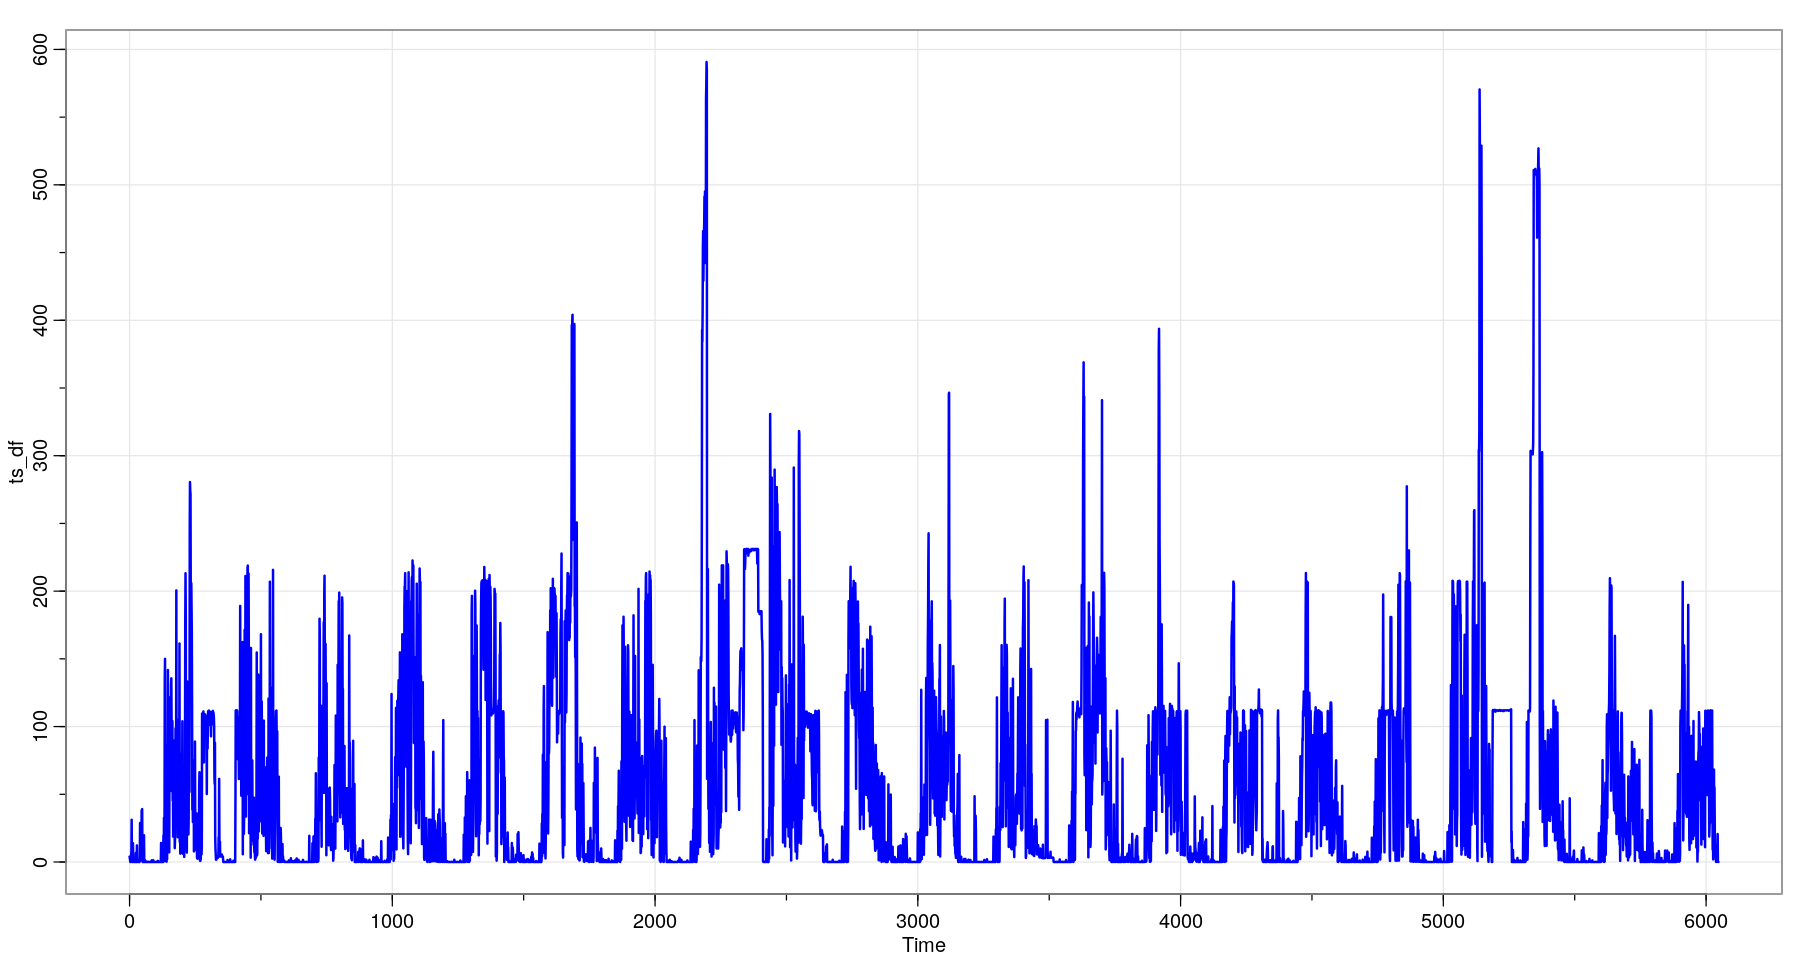

In [4]:
tsplot(ts_df, lwd=2, col=4)

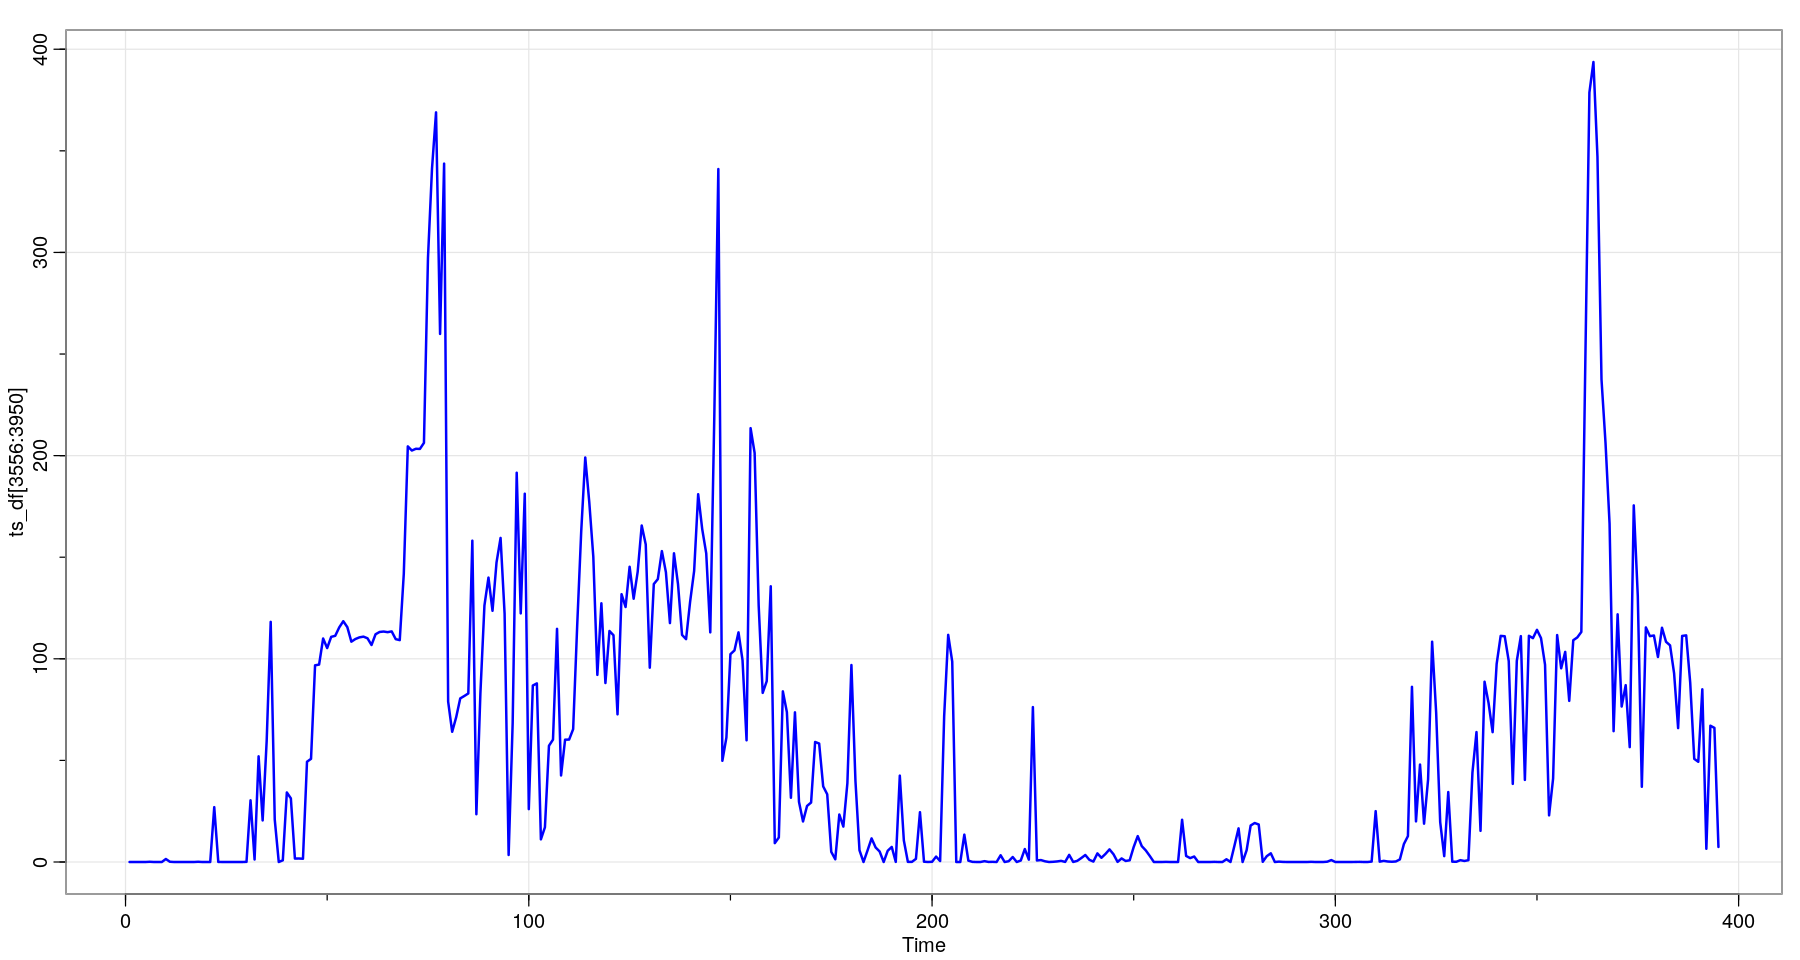

In [5]:
tsplot(ts_df[3556:3950], lwd=2, col=4)


Call:
lm(formula = ldn ~ time(ldn))

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6264 -2.4838  0.4439  1.9441  3.7959 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.565e+00  5.190e-02  49.417   <2e-16 ***
time(ldn)   1.022e-05  1.486e-05   0.688    0.492    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.018 on 6046 degrees of freedom
Multiple R-squared:  7.823e-05,	Adjusted R-squared:  -8.715e-05 
F-statistic: 0.473 on 1 and 6046 DF,  p-value: 0.4916


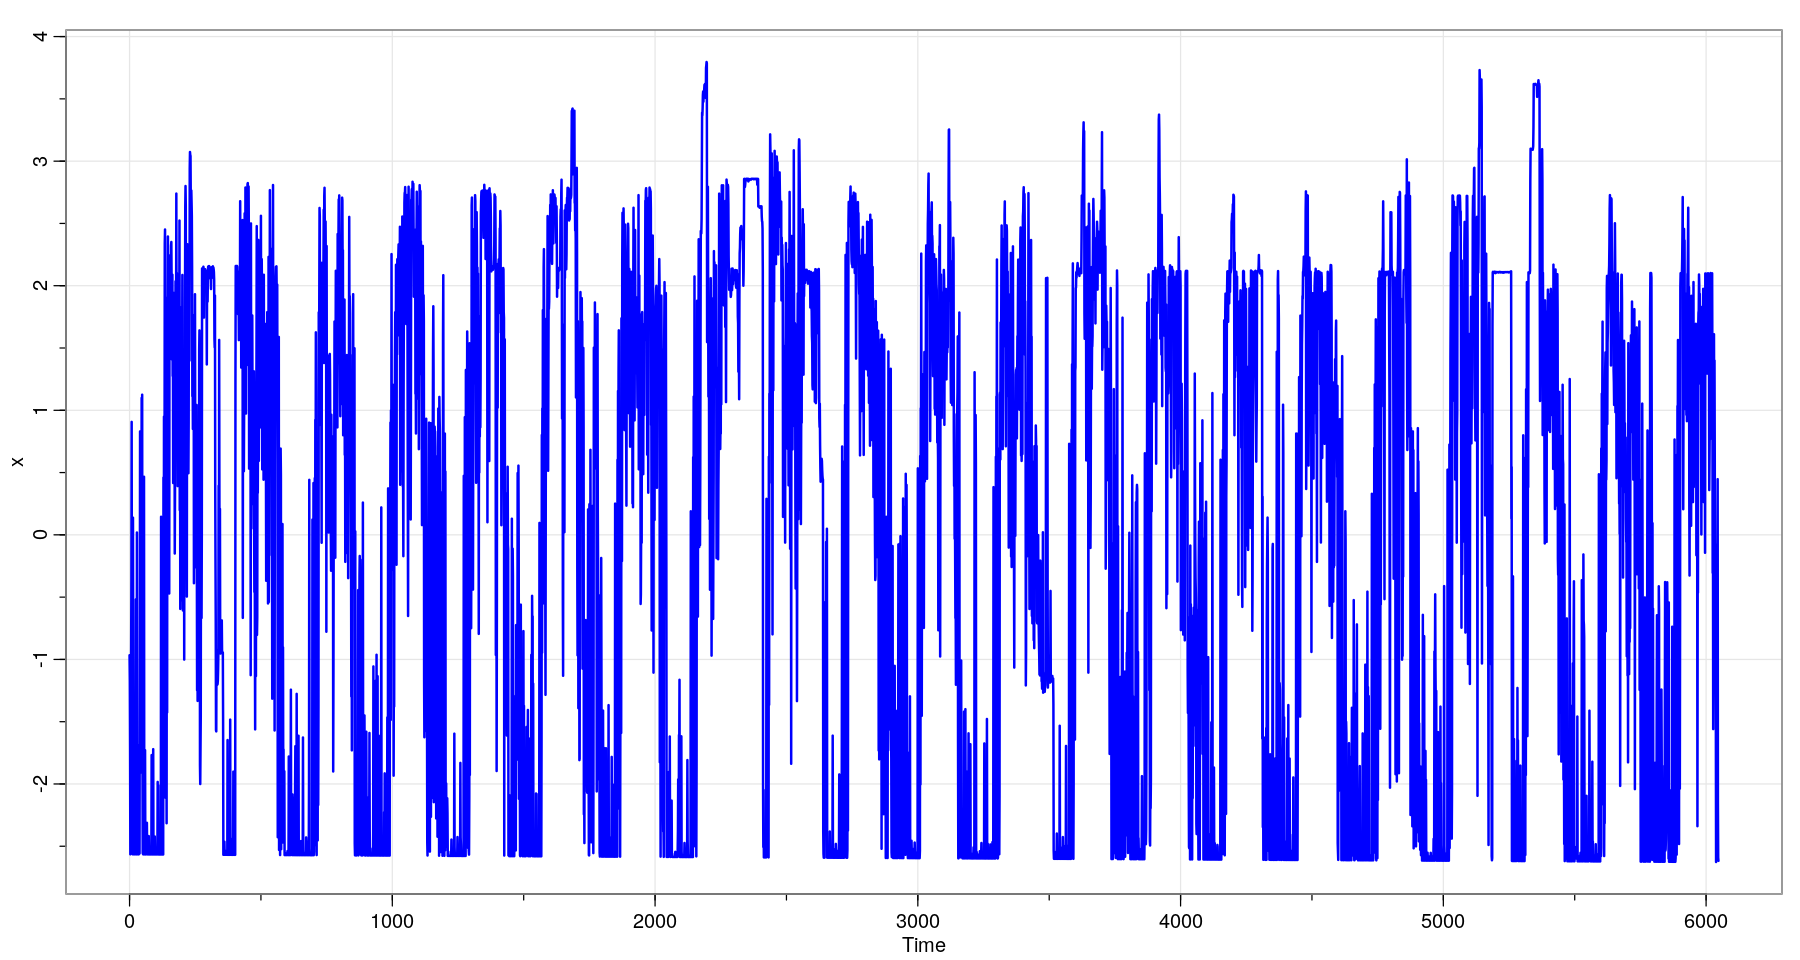

In [6]:
#fit = lm(cmort~time(cmort))
#summary(fit)

ldn = log(ts_df+1)


fit = lm(ldn~time(ldn))
summary(fit)
x=residuals(fit)
x=ts(x, start=0, freq=1)
tsplot(x, lwd=2, col=4)

In [7]:
window=3
pred = 1
x_train = x[time(x)<5184]
n=length(x_train)
print(n)

X_train = matrix(,n-window-pred+1,window)
y_train = matrix(,n-window-pred+1,pred)

for (i in 1:(n-window-pred+1)) {
    X_train[i,] = x_train[i:(i+window-1)]
    y_train[i,] = x_train[(i+window):(i+window+pred-1)]
}
dim(X_train)
dim(y_train)

head(X_train)
head(y_train)
head(x_train)

[1] 5184


[1] 5181    3

[1] 5181    1

[,1]       [,2]       [,3]      
[1,] -0.9665825 -1.1751984 -1.7239434
[2,] -1.1751984 -1.7239434 -2.5646699
[3,] -1.7239434 -2.5646699 -2.5541458
[4,] -2.5646699 -2.5541458 -2.5438556
[5,] -2.5541458 -2.5438556 -0.9672435
[6,] -2.5438556 -0.9672435 -0.3674599

[,1]      
[1,] -2.5646699
[2,] -2.5541458
[3,] -2.5438556
[4,] -0.9672435
[5,] -0.3674599
[6,]  0.9067523

1          2          3          4          5          6 
-0.9665825 -1.1751984 -1.7239434 -2.5646699 -2.5541458 -2.5438556

In [8]:
# Armo el "tensor" de entrenamiento
X_train = array(X_train, dim = c(n-window-pred+1, window, 1))

#dimensiones: no. muestras, tiempos involucrados, no. features
dim(X_train)

[1] 5181    3    1

## Modelo 1: una única capa densa.

Esto coincide con el modelo lineal del autorregresivo que ya vimos.

In [9]:
# initialize our model
model1 <- keras_model_sequential()

model1 %>%
    layer_flatten(input_shape = dim(X_train)[2:3]) %>%
    layer_dense(units = 1)

In [10]:
summary(model1)

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
flatten (Flatten)                   (None, 3)                       0           
________________________________________________________________________________
dense (Dense)                       (None, 1)                       4           
Total params: 4
Trainable params: 4
Non-trainable params: 0
________________________________________________________________________________


In [11]:
model1 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [12]:
trained_model <- model1 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 300, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



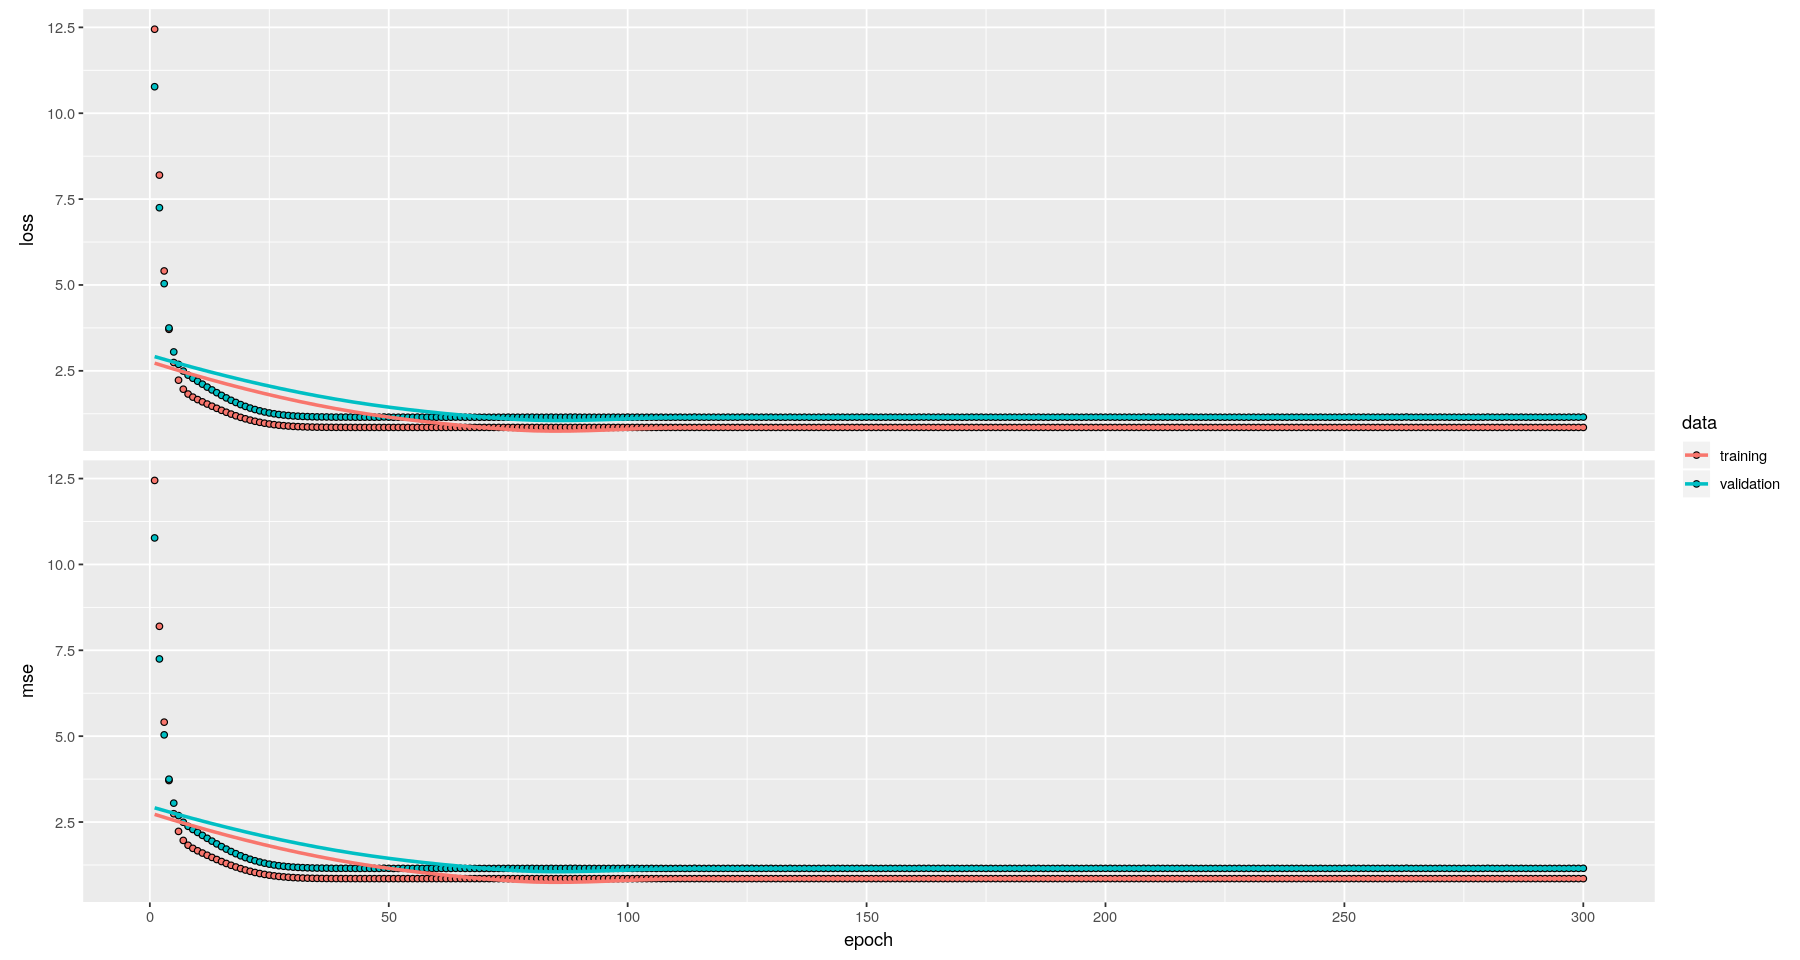

In [13]:
plot(trained_model)

In [14]:
evaluate(model1,X_train,y_train)

loss       mse 
0.8828686 0.8828686

In [15]:
model1$weights

[[1]]
<tf.Variable 'dense/kernel:0' shape=(3, 1) dtype=float32, numpy=
array([[0.1713325 ],
       [0.21924575],
       [0.54924417]], dtype=float32)>

[[2]]
<tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([-0.00154781], dtype=float32)>


In [16]:
arima(x_train,order = c(3,0,0), method="CSS")


Call:
arima(x = x_train, order = c(3, 0, 0), method = "CSS")

Coefficients:
         ar1     ar2     ar3  intercept
      0.5416  0.2164  0.1665     0.0045
s.e.  0.0137  0.0153  0.0137     0.1729

sigma^2 estimated as 0.882:  part log likelihood = -7030.32

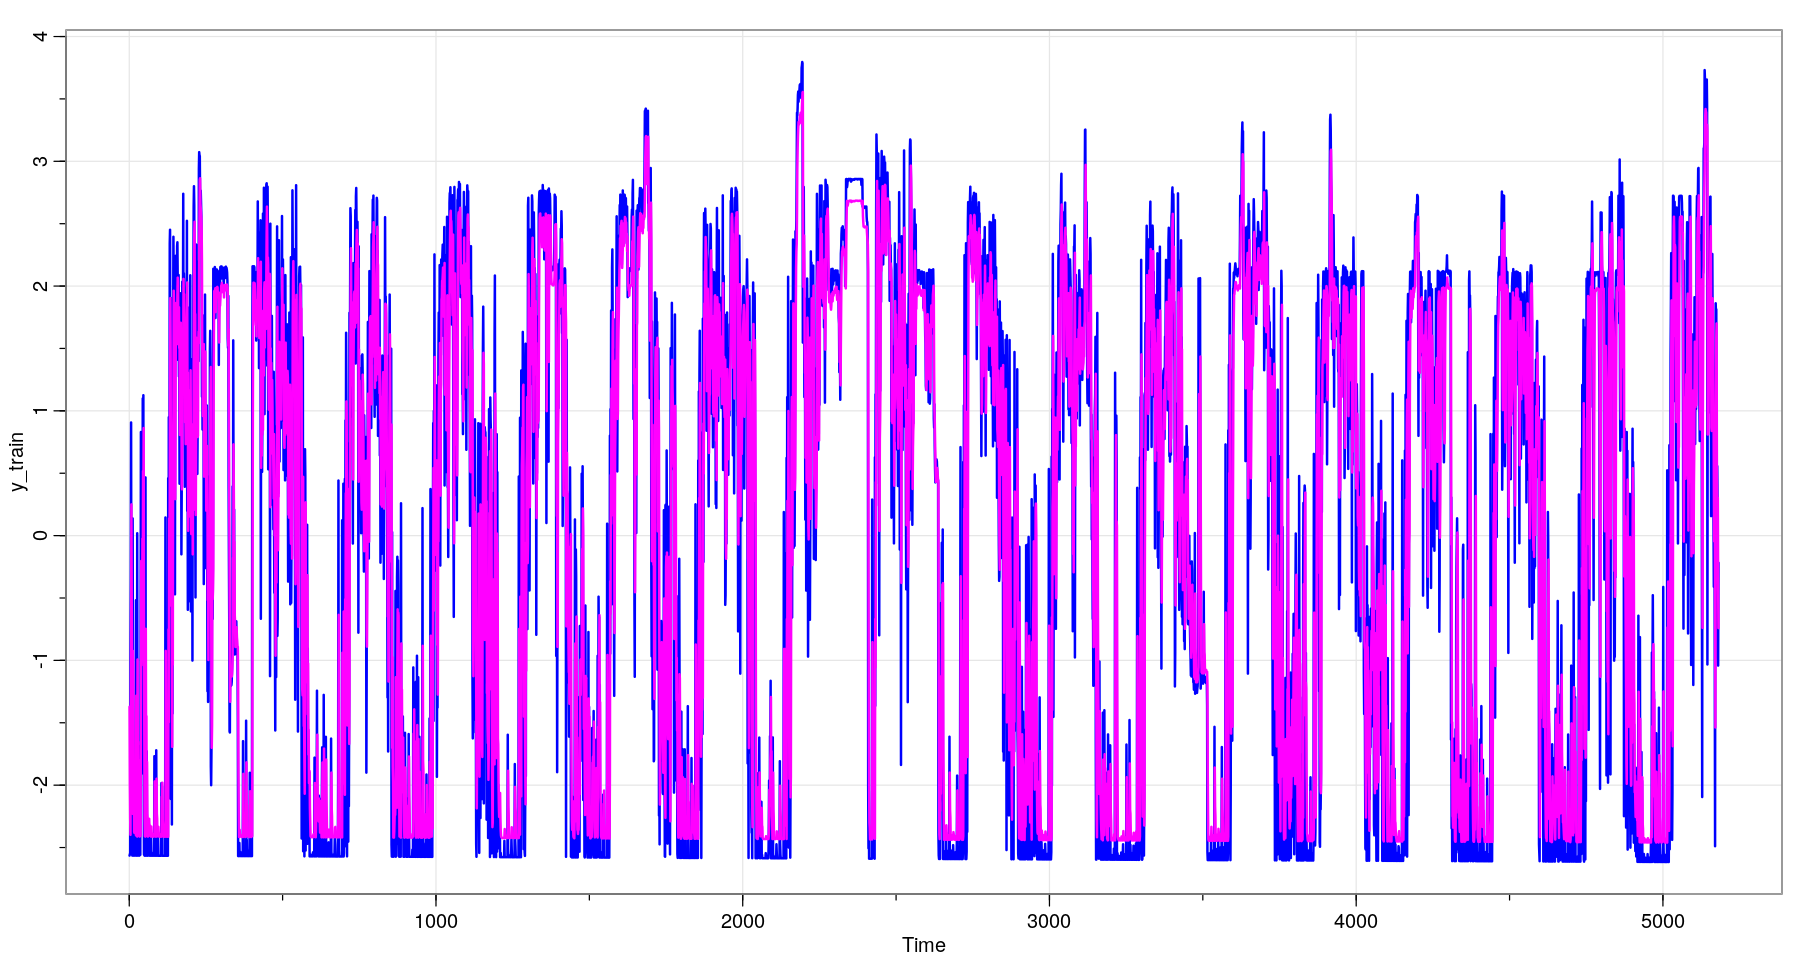

In [17]:
y1 = predict(model1,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y1, col=6, lwd=2)

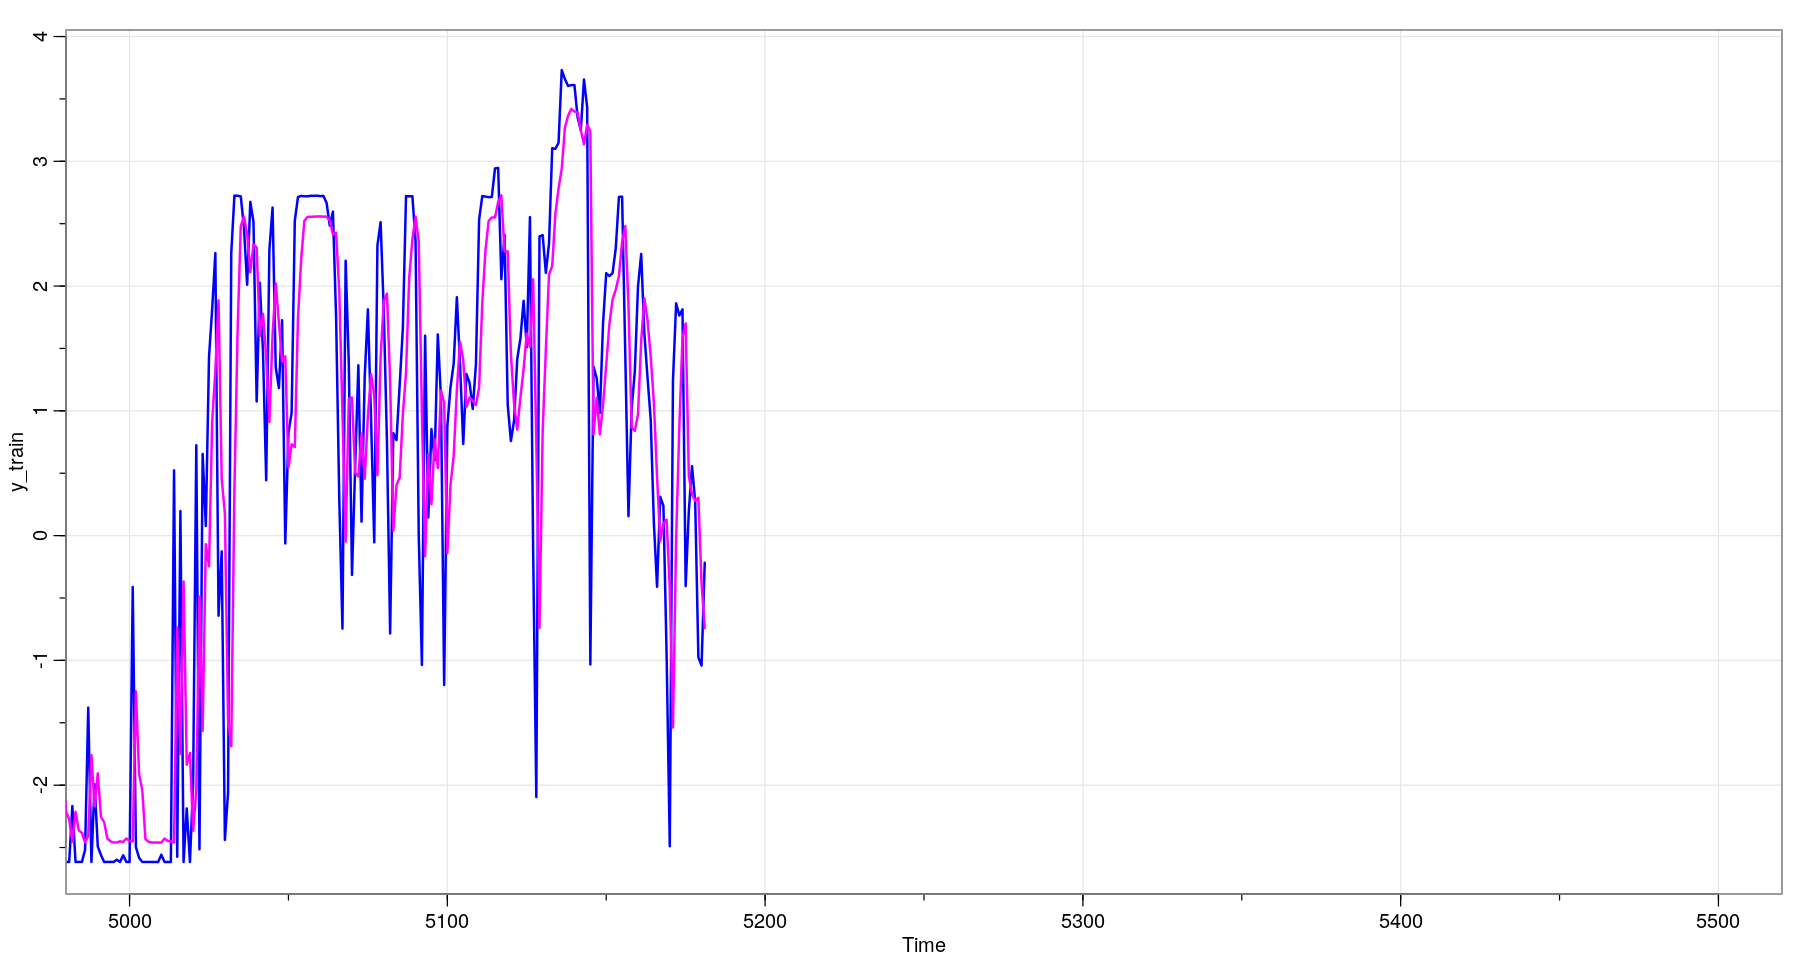

In [18]:
tsplot(y_train, col=4, lwd=2, xlim=c(5000,5500))
lines(y1, col=6, lwd=2)

## Modelo 2: múltiples capas densas

Agreguemos algunas capas para darle no linealidad al modelo. Usamos como función de activación `relu`, es decir $a(x)=\max\{x,0\}$.

In [19]:
# initialize our model
model2 <- keras_model_sequential()

model2 %>%
    layer_flatten(input_shape = dim(X_train)[2:3]) %>%
    layer_dense(units=32, activation='relu') %>%
    layer_dense(units = 1)

In [20]:
summary(model2)

Model: "sequential_1"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
flatten_1 (Flatten)                 (None, 3)                       0           
________________________________________________________________________________
dense_1 (Dense)                     (None, 32)                      128         
________________________________________________________________________________
dense_2 (Dense)                     (None, 1)                       33          
Total params: 161
Trainable params: 161
Non-trainable params: 0
________________________________________________________________________________


In [21]:
model2 %>% compile(loss = 'mse', 
                  optimizer = 'adam',
                  metrics = c('mse'))

In [22]:
trained_model2 <- model2 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


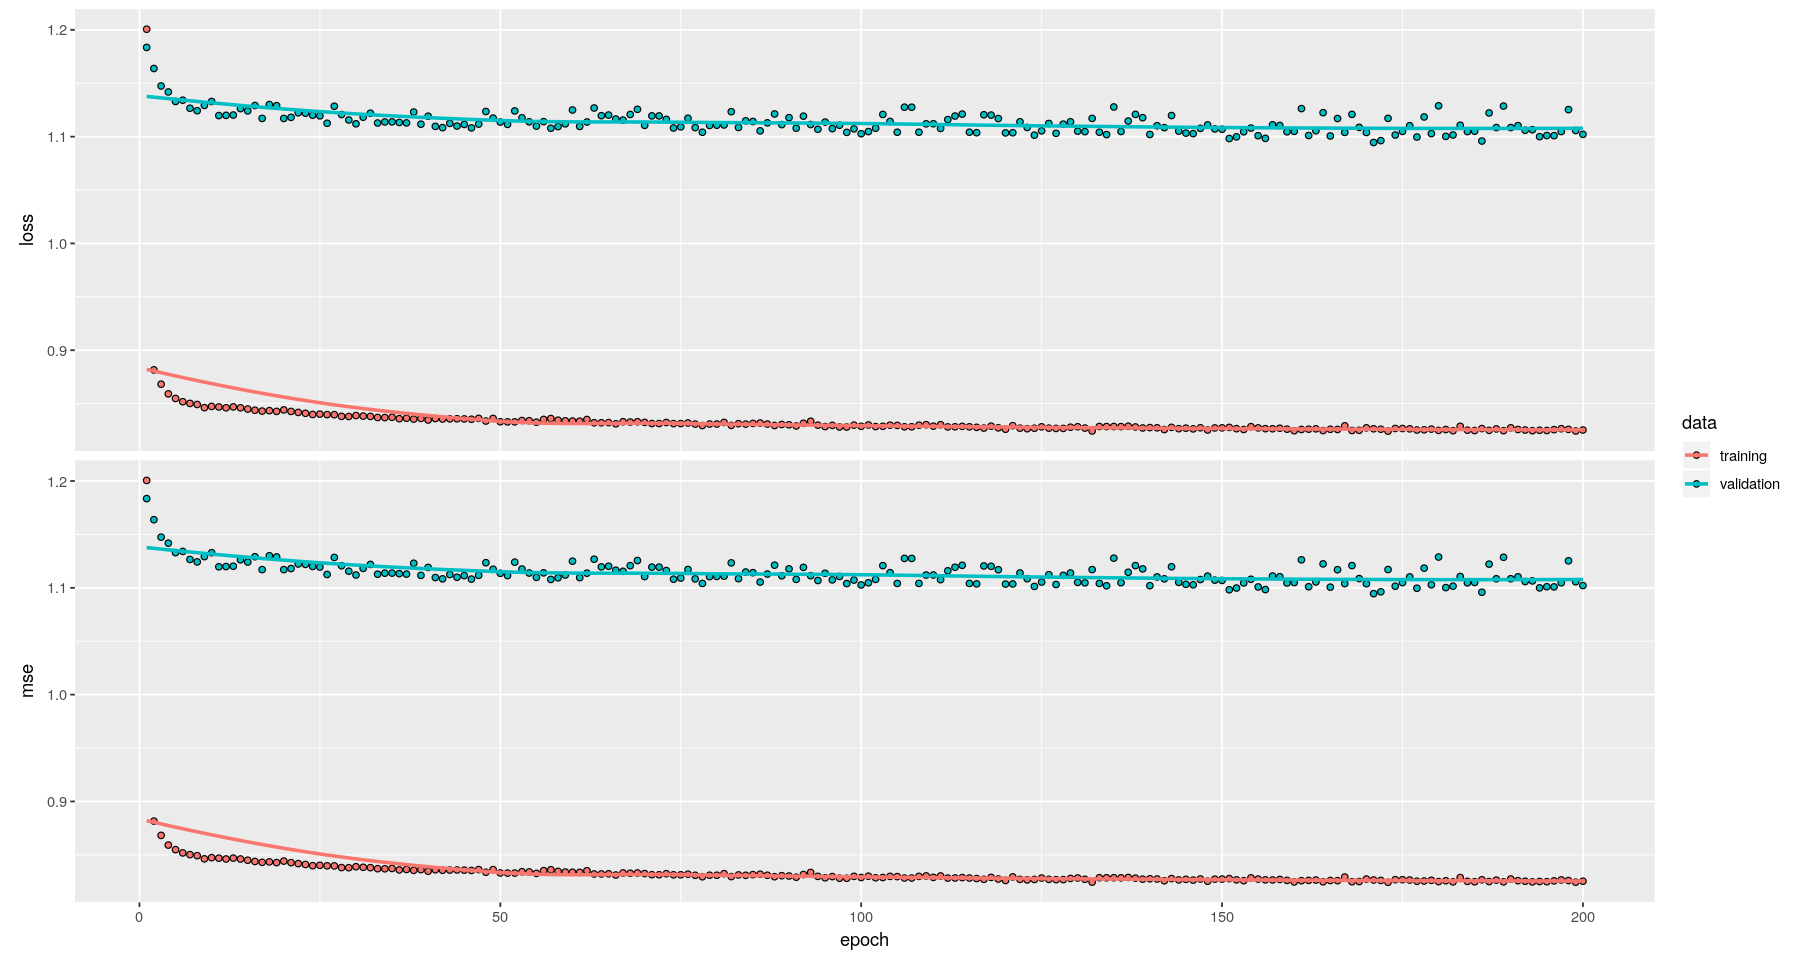

In [23]:
plot(trained_model2)

In [24]:
evaluate(model2,X_train,y_train)

loss       mse 
0.8496384 0.8496384

In [25]:
y2 = predict(model2,X_train)

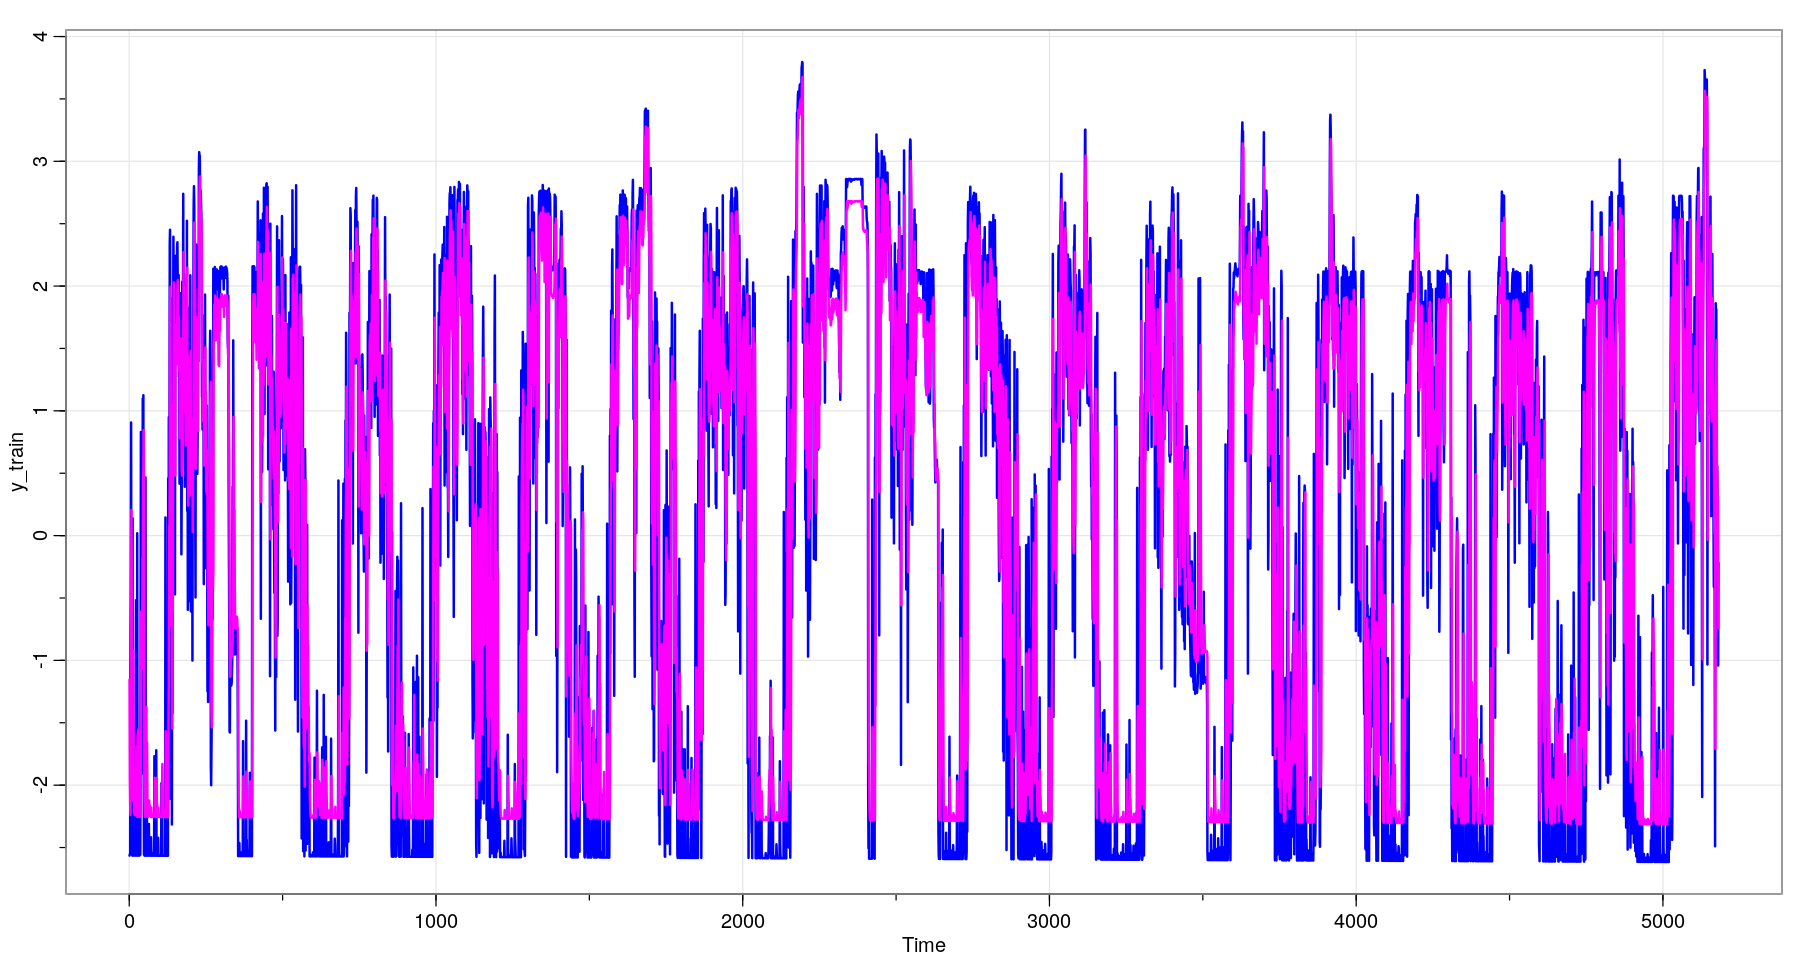

In [26]:
tsplot(y_train, col=4, lwd=2)
lines(y2, col=6, lwd=2)

## Modelo 3: agregando características

Agreguemos ahora al conjunto de entrenamiento algunas funciones del tiempo. Por ejemplo, el momento del año usando $\sin$ y $\cos$ como antes

In [27]:
window=3
pred = 1
x_train = x[time(x)<5500]
sint = sin(2*pi*time(x))
cost = cos(2*pi*time(x))

n=length(x_train)

X_train = array(,dim=c(n-window-pred+1,window,3)) #el ultimo son los features
y_train = matrix(,n-window-pred+1,pred)

for (i in 1:(n-window-pred+1)) {
    X_train[i,,1] = x_train[i:(i+window-1)]
    X_train[i,,2] = sint[i:(i+window-1)]
    X_train[i,,3] = cost[i:(i+window-1)]
    y_train[i,] = x_train[(i+window):(i+window+pred-1)]
}
dim(X_train)
dim(y_train)

[1] 5497    3    3

[1] 5497    1

In [28]:
# initialize our model
model3 <- keras_model_sequential()

model3 %>%
    layer_flatten(input_shape = dim(X_train)[2:3]) %>%
    layer_dense(units = 1)

In [29]:
summary(model3)

Model: "sequential_2"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
flatten_2 (Flatten)                 (None, 9)                       0           
________________________________________________________________________________
dense_3 (Dense)                     (None, 1)                       10          
Total params: 10
Trainable params: 10
Non-trainable params: 0
________________________________________________________________________________


In [30]:
model3 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [31]:
trained_model3 <- model3 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


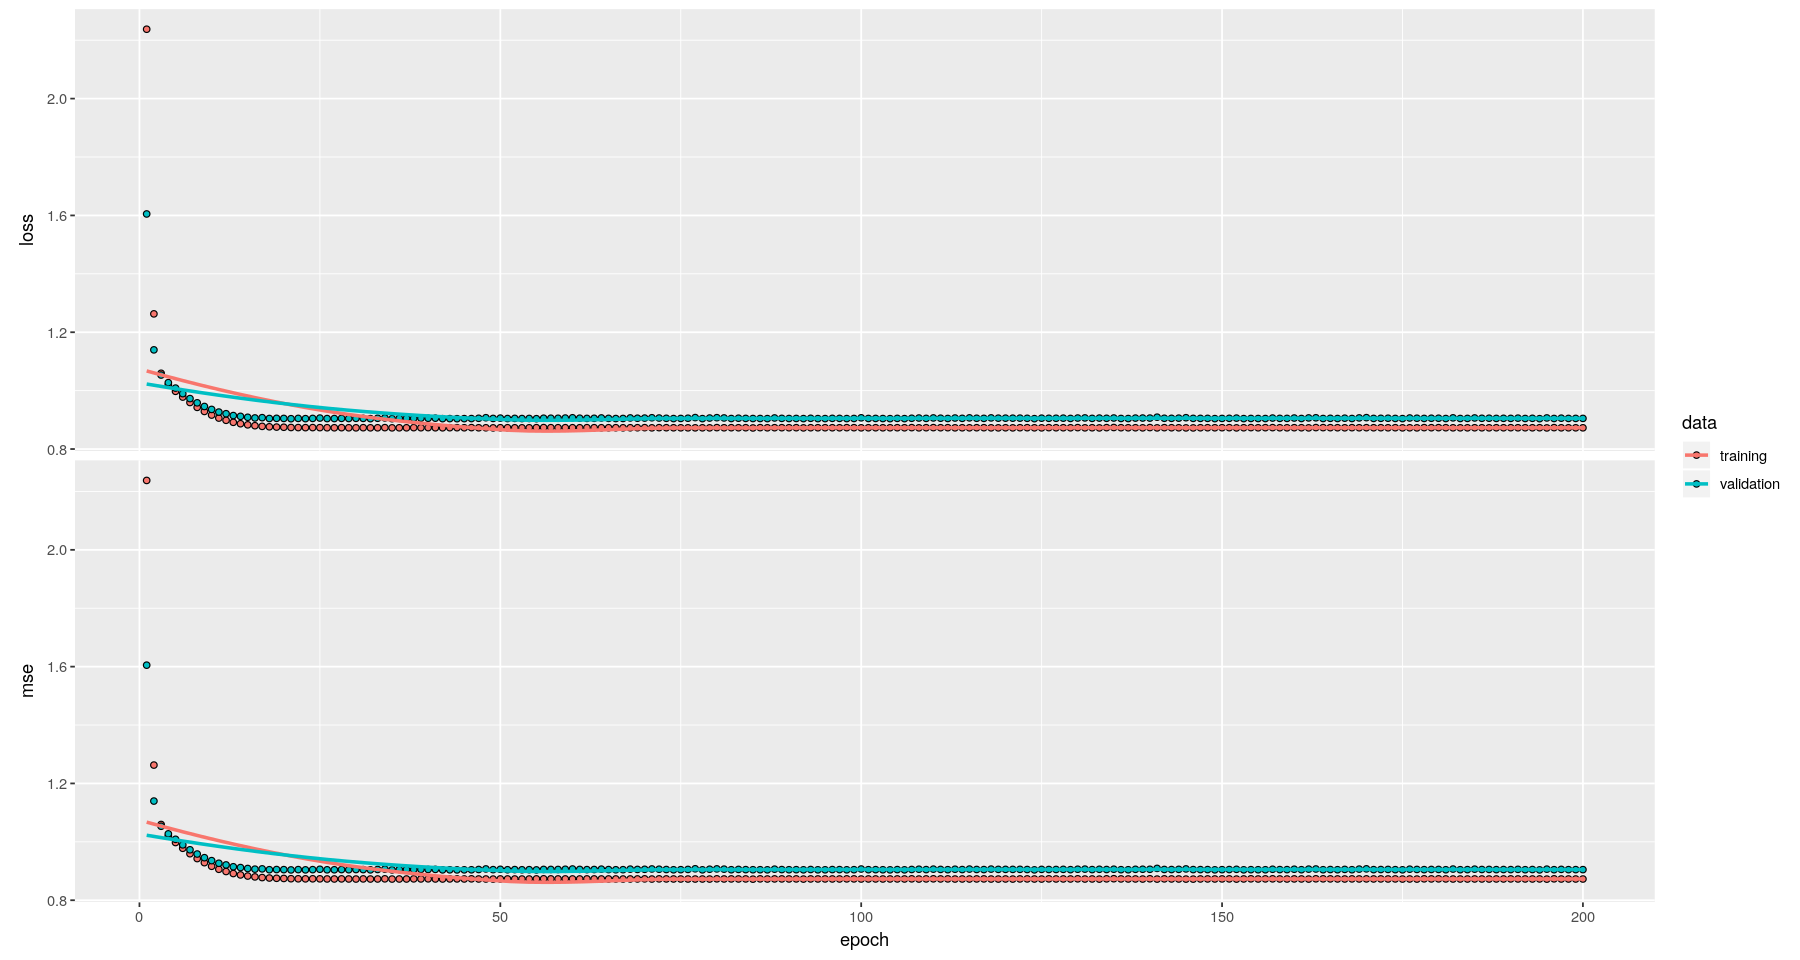

In [32]:
plot(trained_model3)

In [33]:
model3$weights

[[1]]
<tf.Variable 'dense_3/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.17040358],
       [ 0.03463279],
       [ 0.04400602],
       [ 0.222584  ],
       [-0.3555913 ],
       [ 0.5049076 ],
       [ 0.54601043],
       [-0.23813707],
       [-0.445375  ]], dtype=float32)>

[[2]]
<tf.Variable 'dense_3/bias:0' shape=(1,) dtype=float32, numpy=array([-0.10194729], dtype=float32)>


In [34]:
evaluate(model3, X_train, y_train)

loss       mse 
0.8757168 0.8757168

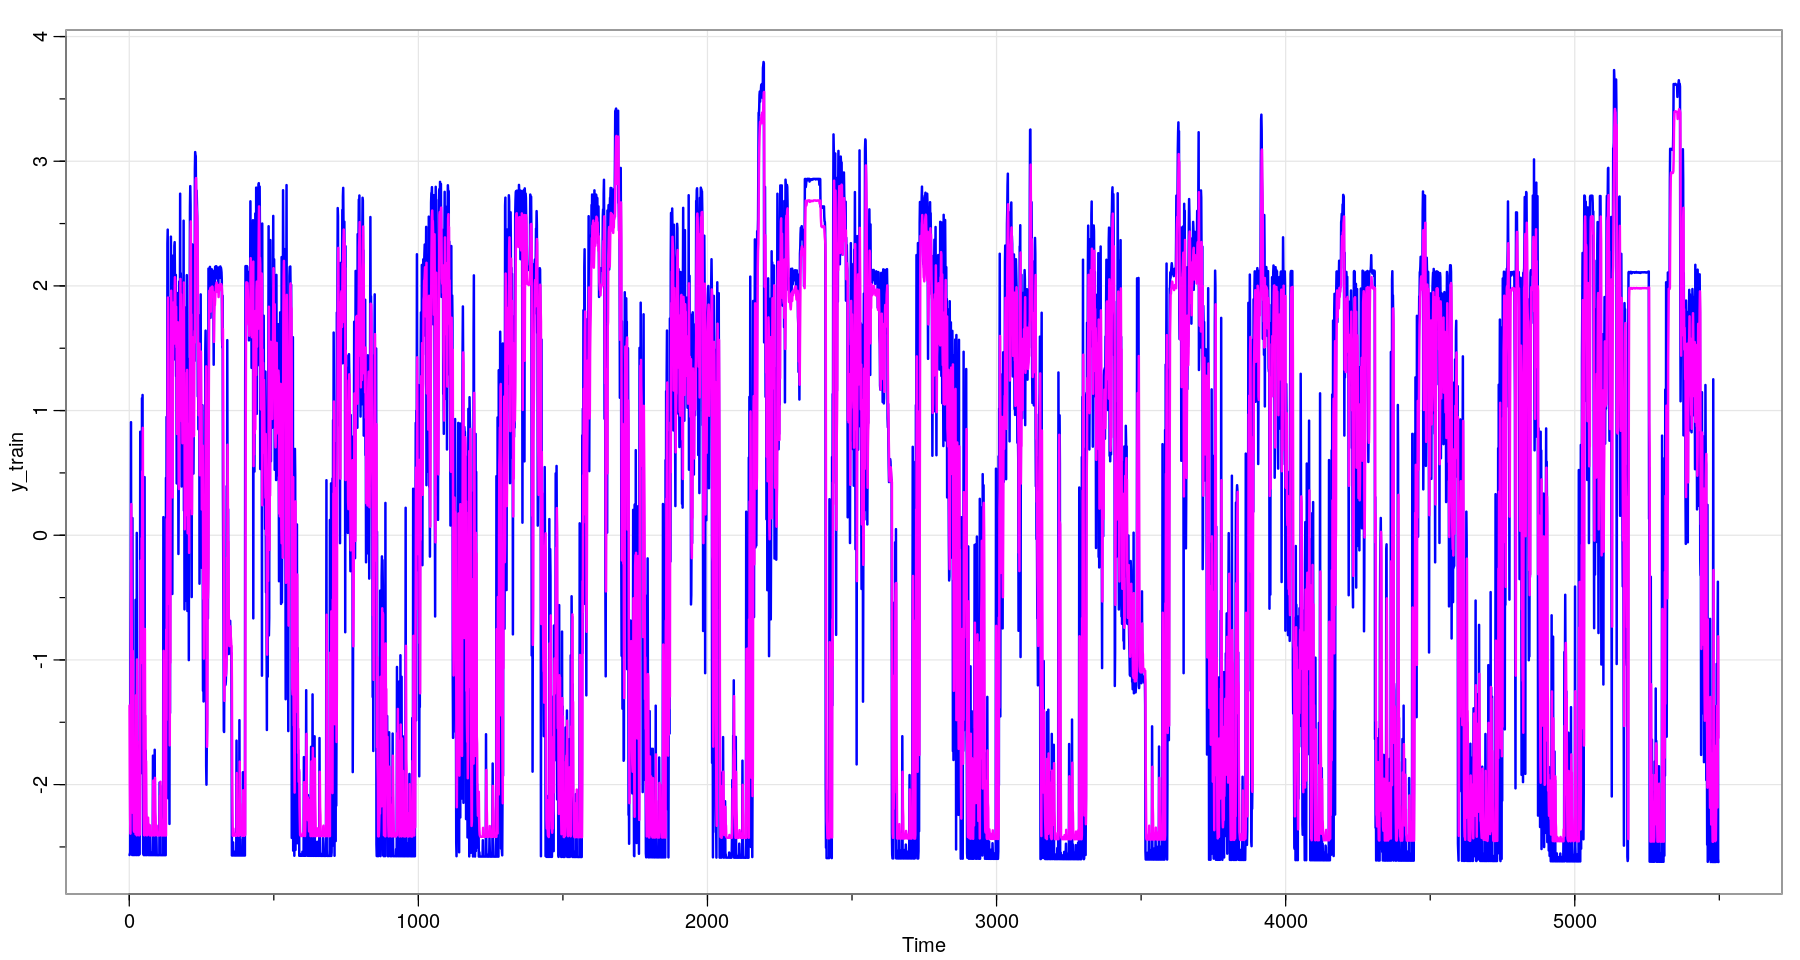

In [35]:
y3 = predict(model3,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y3, col=6, lwd=2)

## Modelo 4: características y capas

Agreguemos un par de capas densas intermedias

In [36]:
# initialize our model
model4 <- keras_model_sequential()

model4 %>%
    layer_flatten(input_shape = dim(X_train)[2:3]) %>%
    layer_dense(units = 32, activation="relu") %>%
    layer_dense(units = 16, activation="relu") %>%
    layer_dense(units = 1)

In [37]:
summary(model4)

Model: "sequential_3"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
flatten_3 (Flatten)                 (None, 9)                       0           
________________________________________________________________________________
dense_4 (Dense)                     (None, 32)                      320         
________________________________________________________________________________
dense_5 (Dense)                     (None, 16)                      528         
________________________________________________________________________________
dense_6 (Dense)                     (None, 1)                       17          
Total params: 865
Trainable params: 865
Non-trainable params: 0
________________________________________________________________________________


In [38]:
model4 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [39]:
trained_model4 <- model4 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


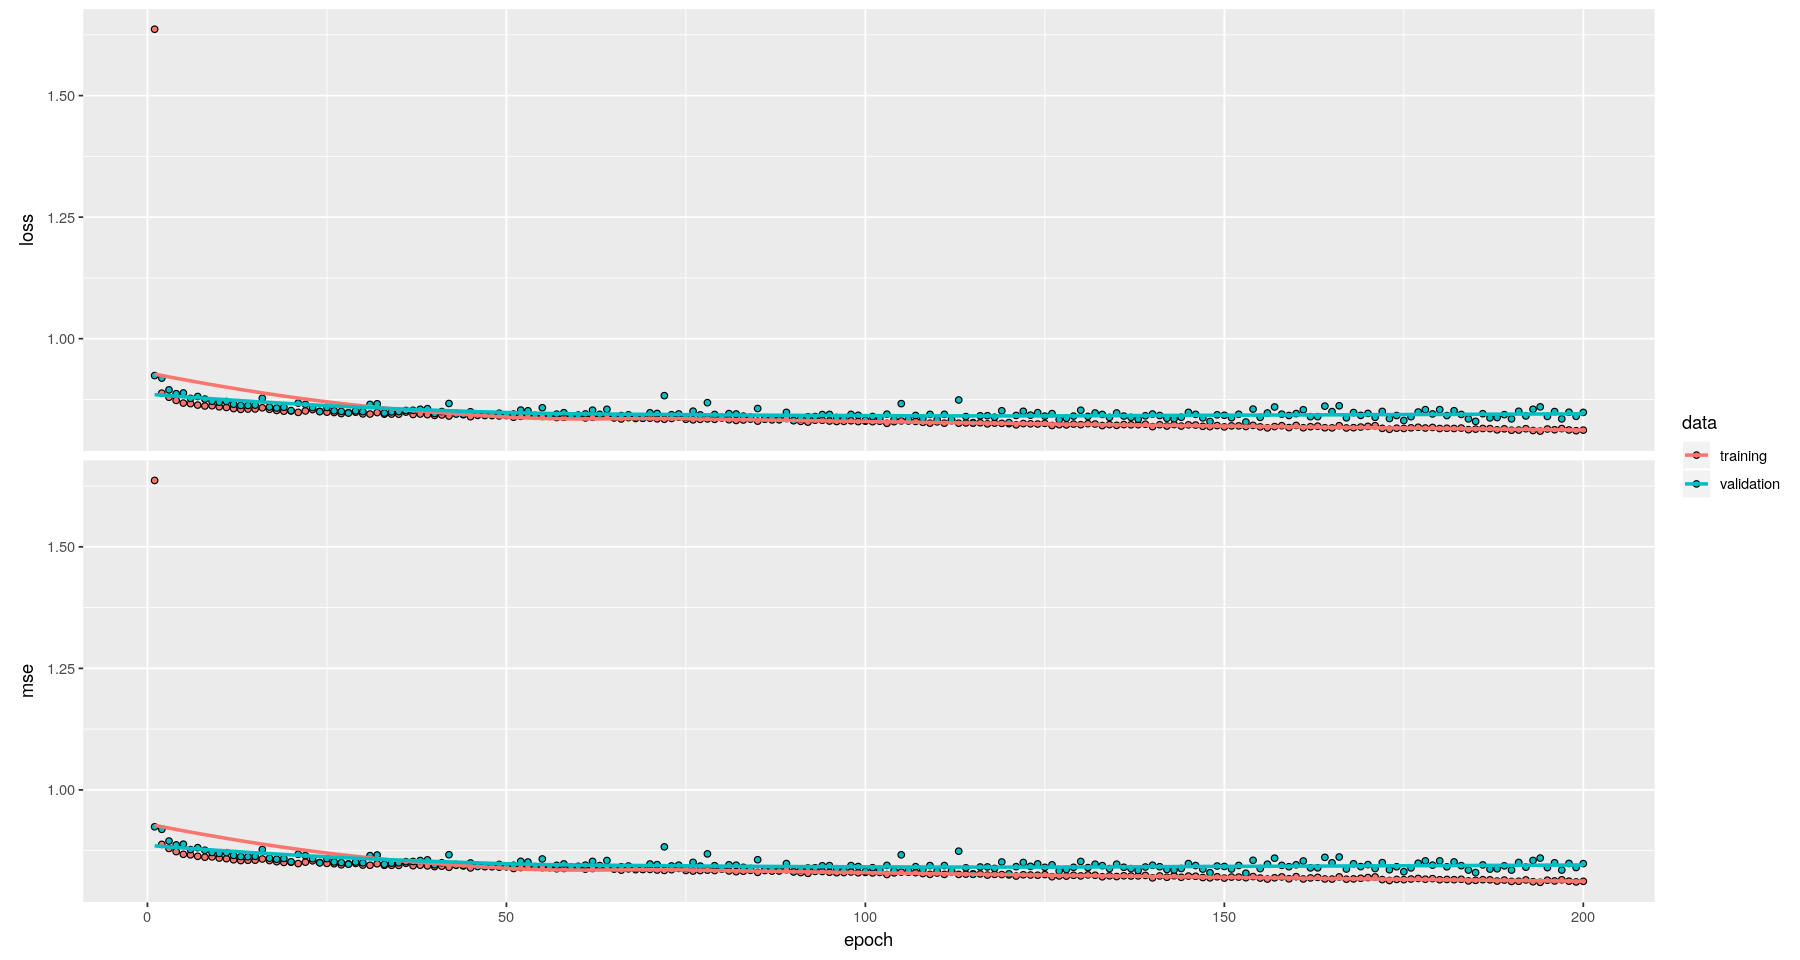

In [40]:
plot(trained_model4)

In [41]:
evaluate(model4, X_train, y_train)

loss       mse 
0.8169304 0.8169304

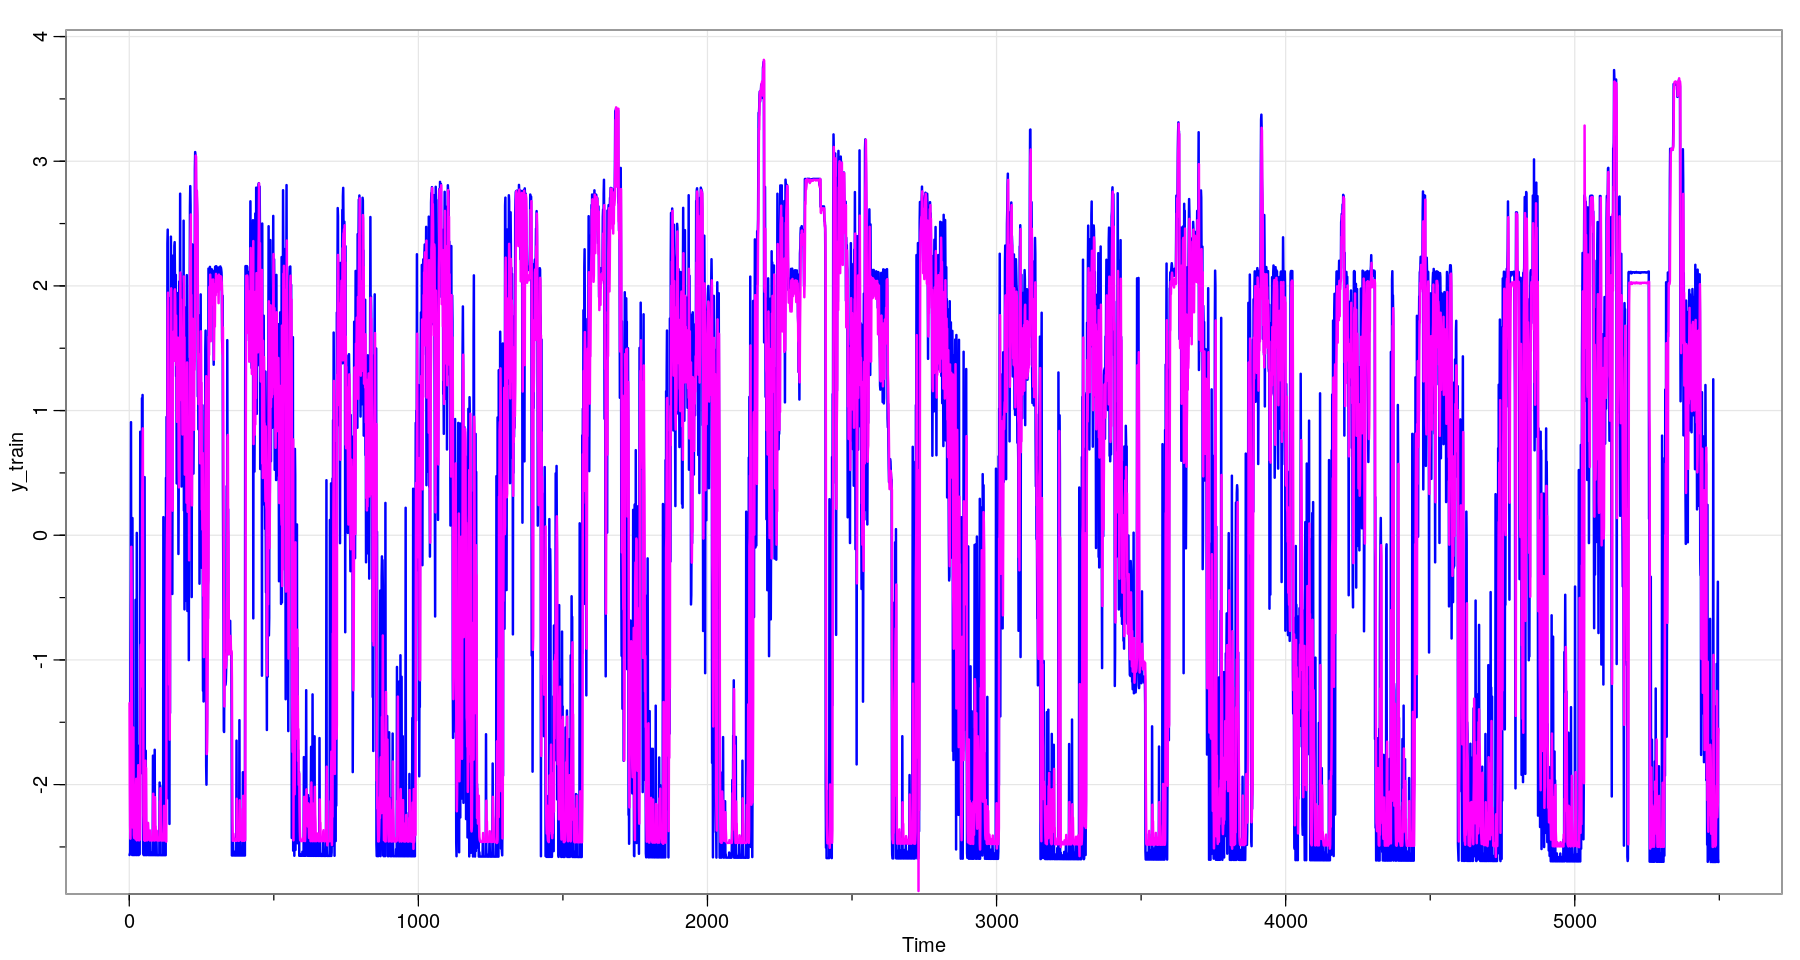

In [42]:
y4 = predict(model4,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y4, col=6, lwd=2)

## Modelo 5: Convolutional Neural Network

La idea de la capa convolucional o CNN es similar a la de los procesos autorregresivos y a lo que veníamos haciendo antes, solo que simplifica un poco la escritura del modelo. El de abajo es esencialmente el mismo modelo 4 pero usando CNNs.


In [43]:
# initialize our model
model5 <- keras_model_sequential()

model5 %>%
    layer_conv_1d(input_shape = dim(X_train)[2:3], filters = 32, kernel_size=window, activation="relu") %>%
    layer_dense(units = 16, activation="relu") %>%
    layer_dense(units = 1)

In [44]:
summary(model5)

Model: "sequential_4"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv1d (Conv1D)                     (None, 1, 32)                   320         
________________________________________________________________________________
dense_7 (Dense)                     (None, 1, 16)                   528         
________________________________________________________________________________
dense_8 (Dense)                     (None, 1, 1)                    17          
Total params: 865
Trainable params: 865
Non-trainable params: 0
________________________________________________________________________________


In [45]:
model5 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [46]:
trained_model5 <- model5 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


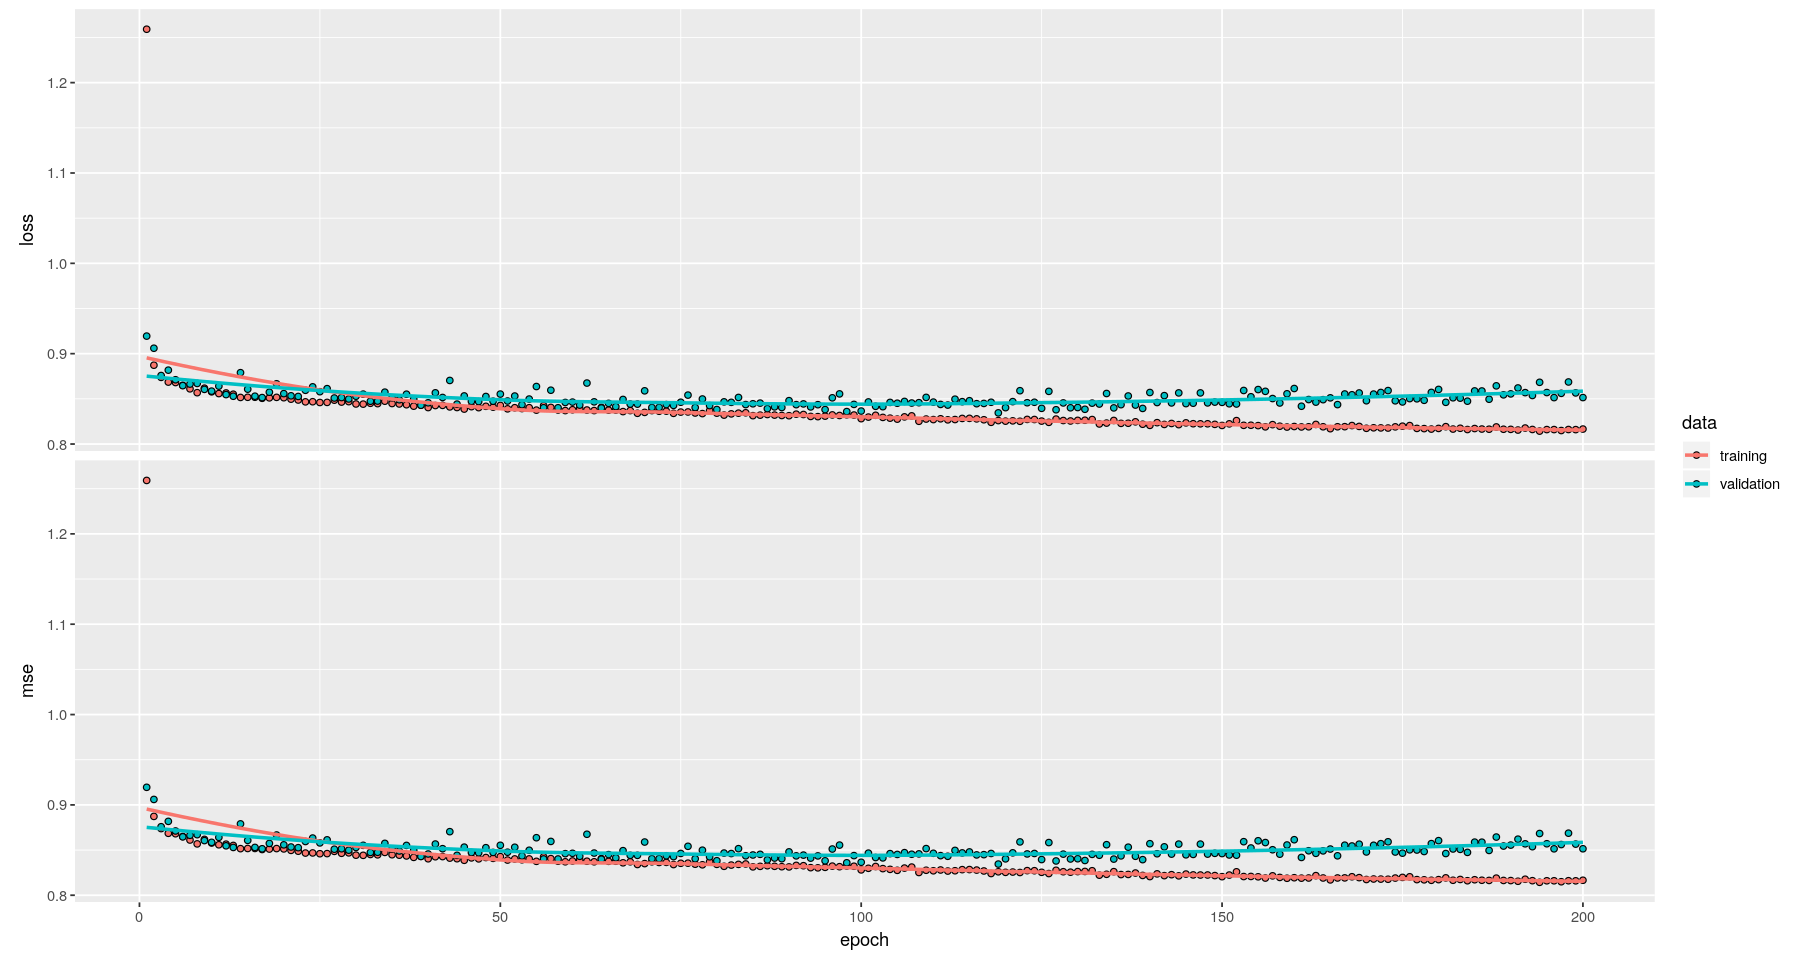

In [47]:
plot(trained_model5)

In [48]:
evaluate(model5, X_train, y_train)

loss       mse 
0.8146941 0.8146941

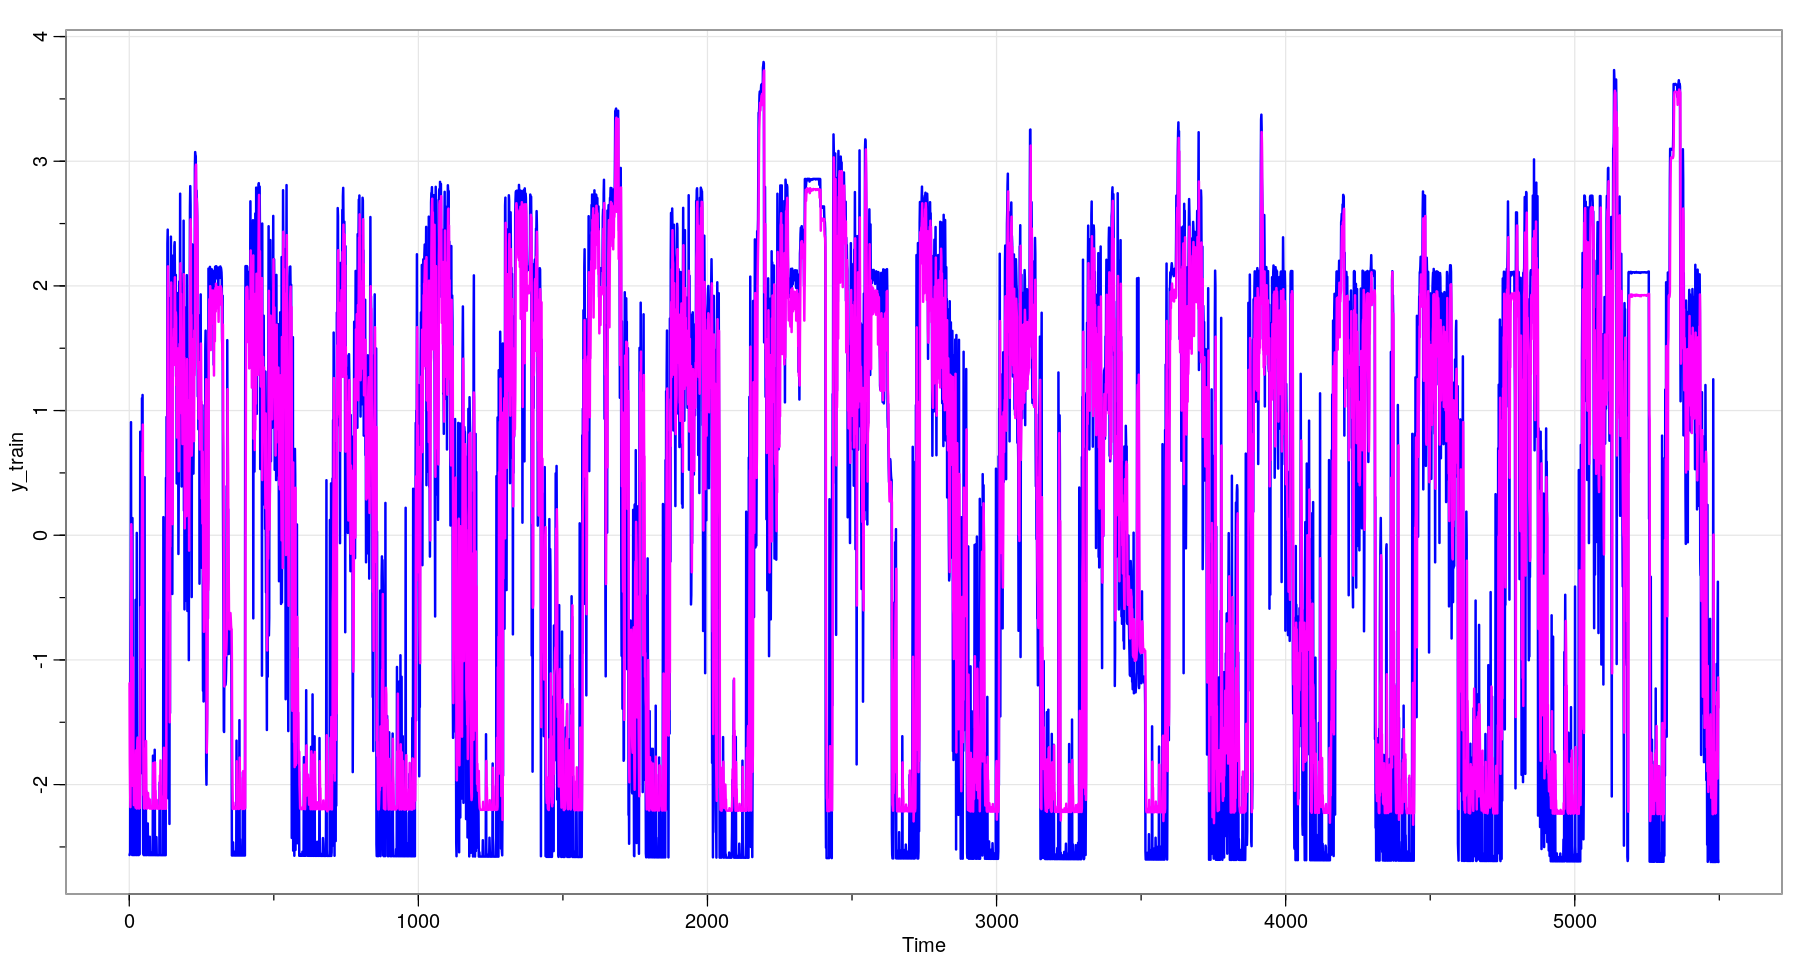

In [49]:
y5 = predict(model5,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y5, col=6, lwd=2)

## Recurrent Neural Networks

Estas redes permiten "guardar estado" y en algún sentido son la generalización no lineal del Dynamic Linear model que ya vimos. Permiten en algún sentido agregar memoria.

El proceso en una capa RNN es:

## Modelo 6: Simple RNN
La red recurrente simple tiene "memoria corta" y presenta problemas de ajuste ("vanishing and exploding gradiemts") cuando uno hace el algoritmo de Backpropagation adaptado a las mismas.

In [50]:
# initialize our model
model6 <- keras_model_sequential()

model6 %>%
    layer_simple_rnn(input_shape = dim(X_train)[2:3], units = 8, activation="relu") %>%
    layer_dense(units = 1)

In [51]:
summary(model6)

Model: "sequential_5"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
simple_rnn (SimpleRNN)              (None, 8)                       96          
________________________________________________________________________________
dense_9 (Dense)                     (None, 1)                       9           
Total params: 105
Trainable params: 105
Non-trainable params: 0
________________________________________________________________________________


In [52]:
model6 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [53]:
trained_model6 <- model6 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


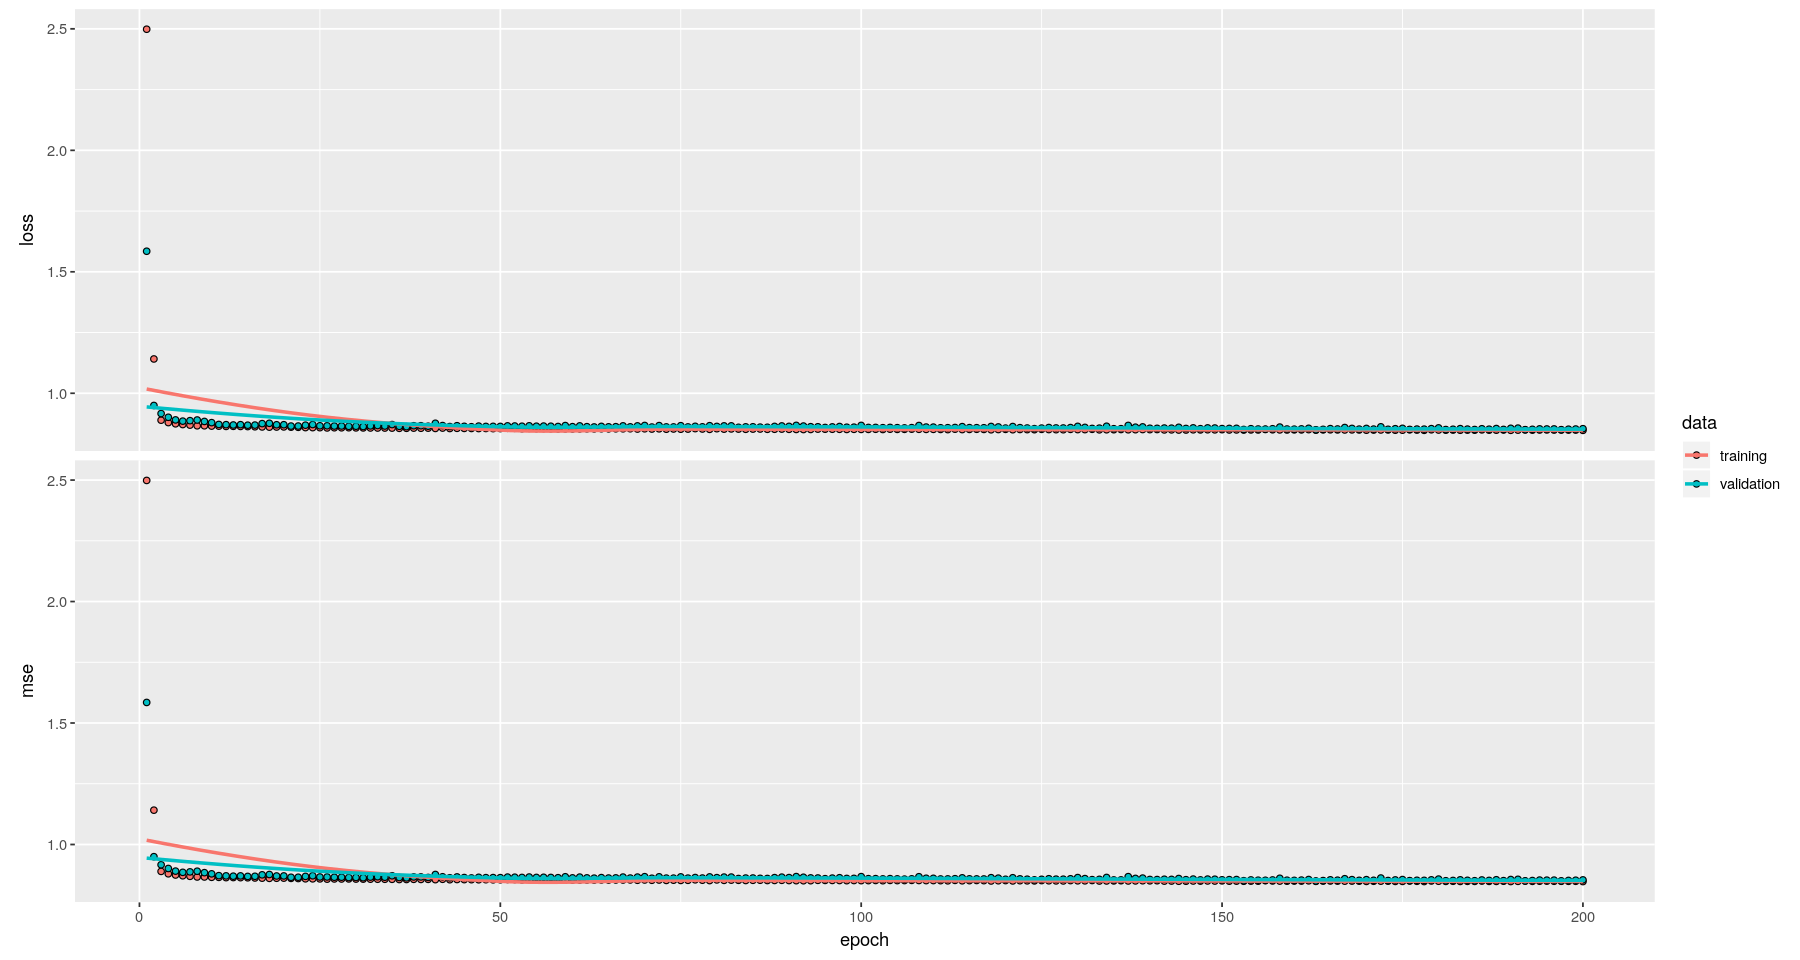

In [54]:
plot(trained_model6)

In [55]:
evaluate(model6, X_train, y_train)

loss       mse 
0.8459392 0.8459392

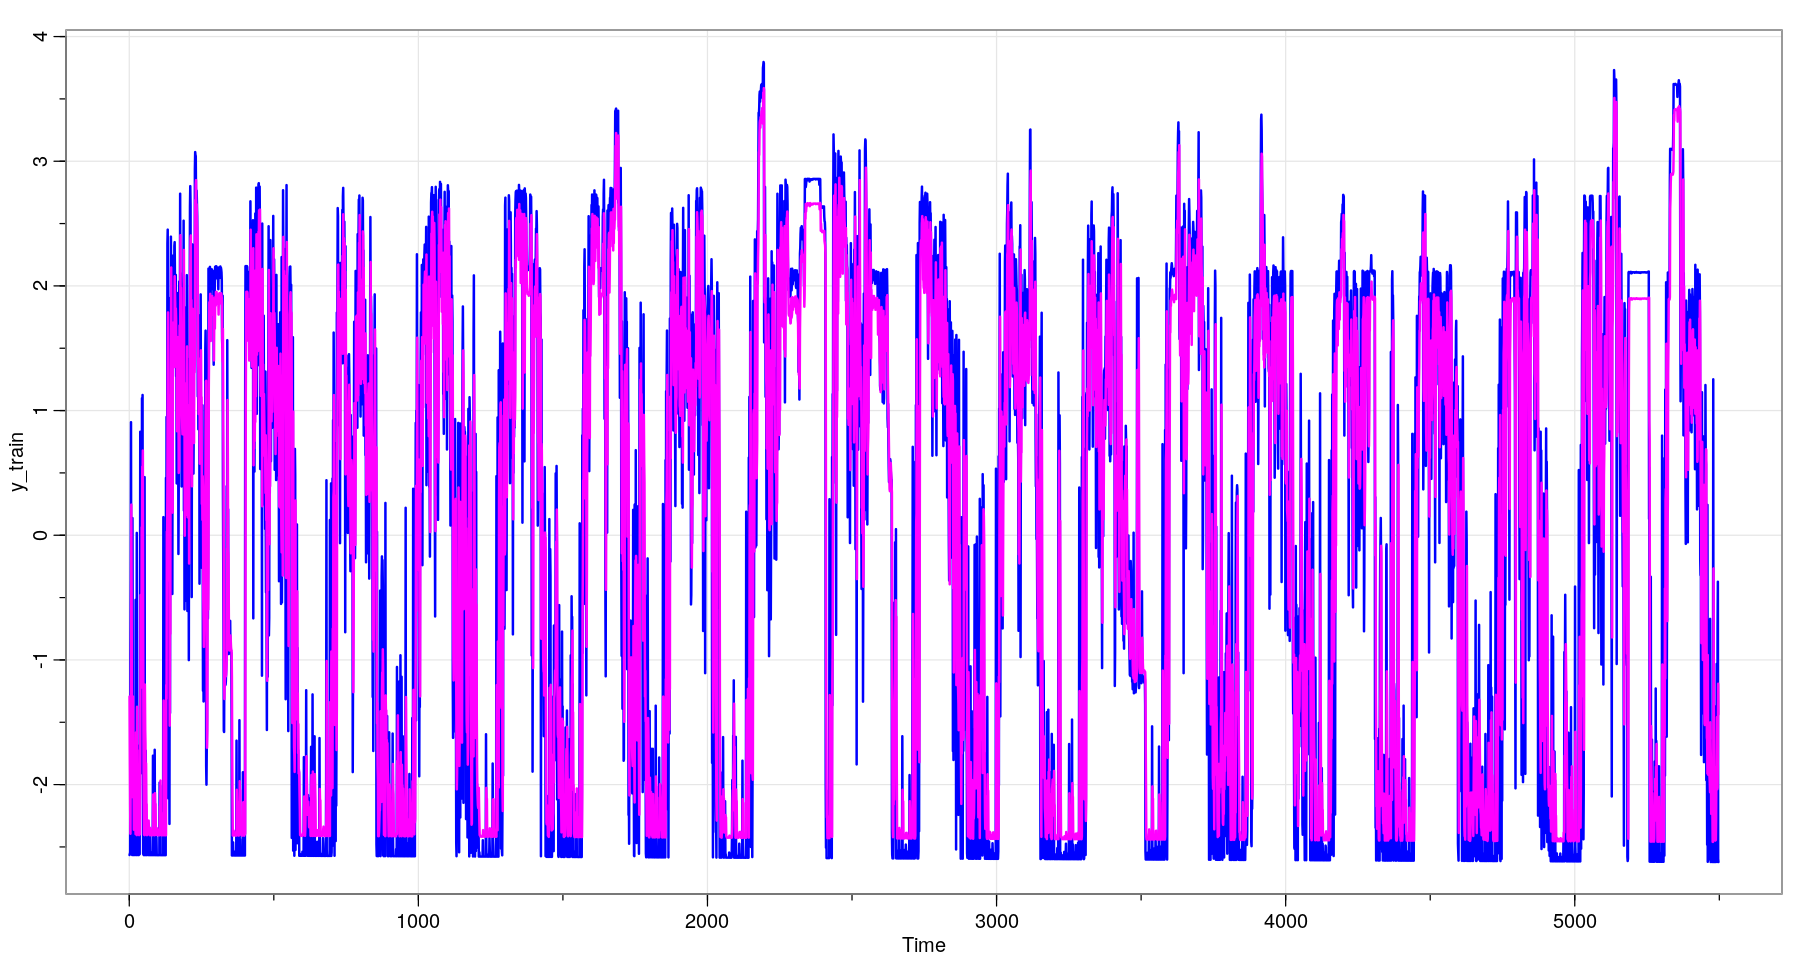

In [56]:
y6 = predict(model6,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y6, col=6, lwd=2)

## Modelo 7: LSTM

La red recurrente LSTM funciona igual que la red RNN en principio, pero tiene más "gates" y parámetros internos para permitir guardar más estado interno. Estas redes son muy usadas para series temporales.

In [57]:
# initialize our model
model7 <- keras_model_sequential()

model7 %>%
    layer_lstm(input_shape = dim(X_train)[2:3], units = 8, activation="relu") %>%
    layer_dense(units = 1)

In [58]:
summary(model7)

Model: "sequential_6"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
lstm (LSTM)                         (None, 8)                       384         
________________________________________________________________________________
dense_10 (Dense)                    (None, 1)                       9           
Total params: 393
Trainable params: 393
Non-trainable params: 0
________________________________________________________________________________


In [59]:
model7 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [60]:
trained_model7 <- model7 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


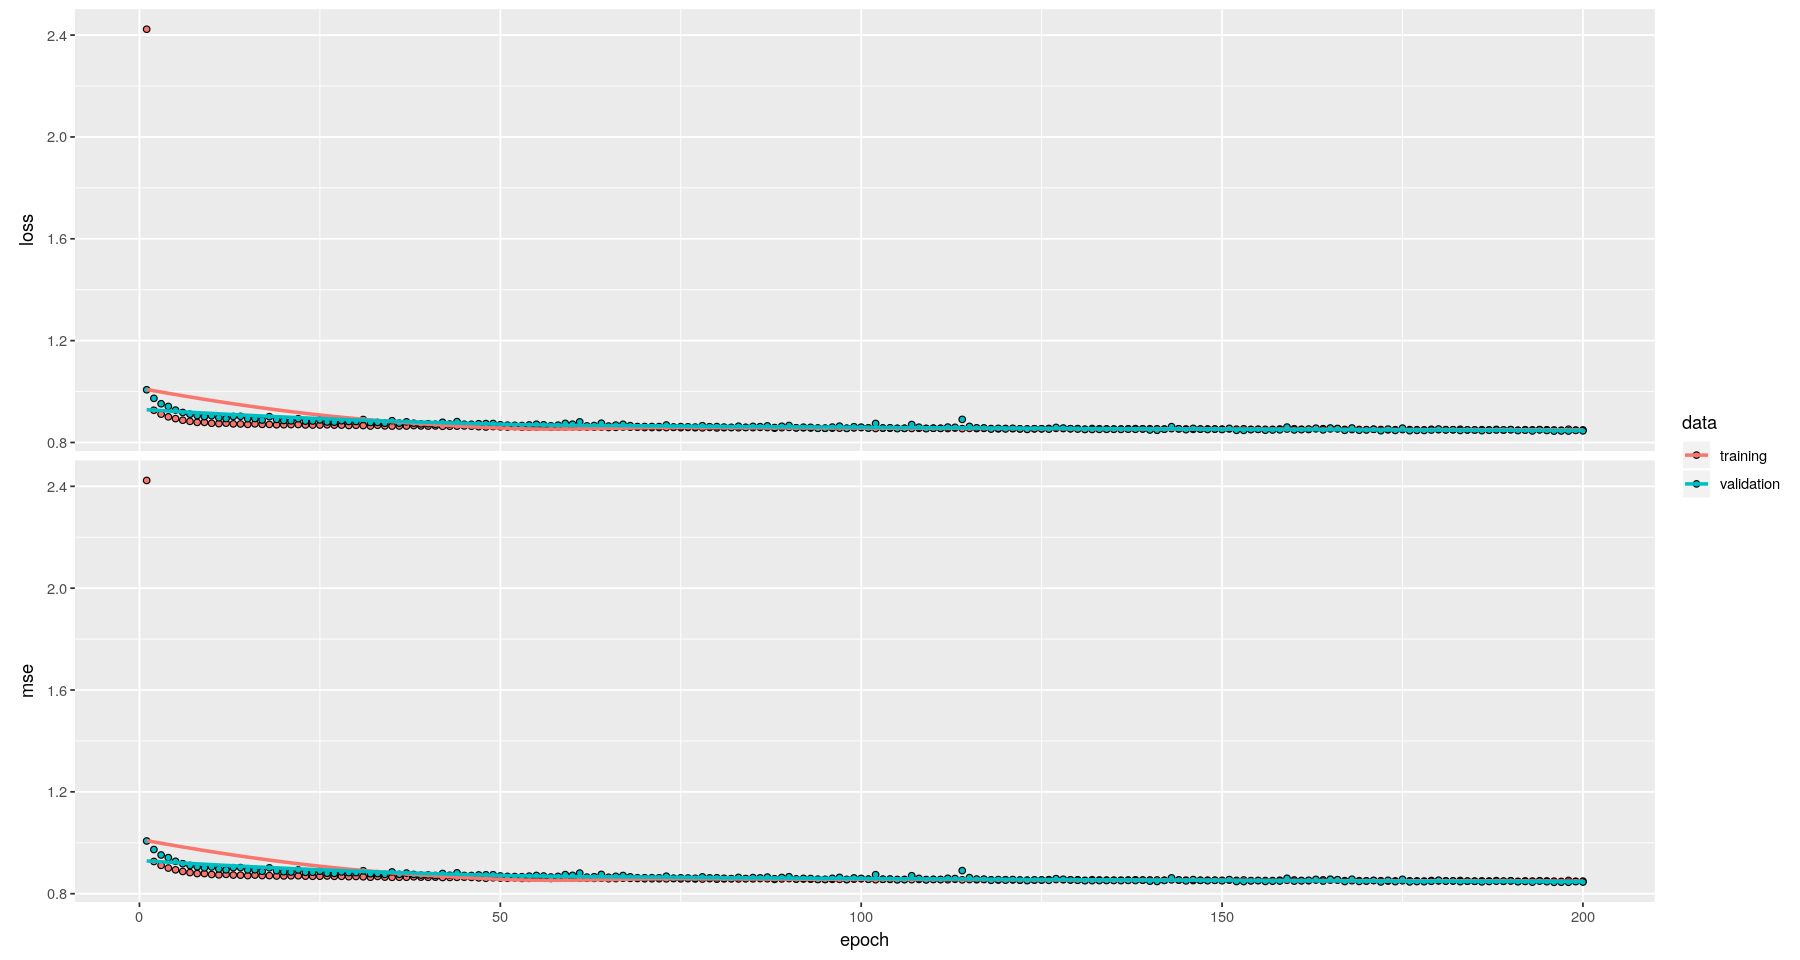

In [61]:
plot(trained_model7)

In [62]:
evaluate(model7, X_train, y_train)

loss       mse 
0.8459255 0.8459255

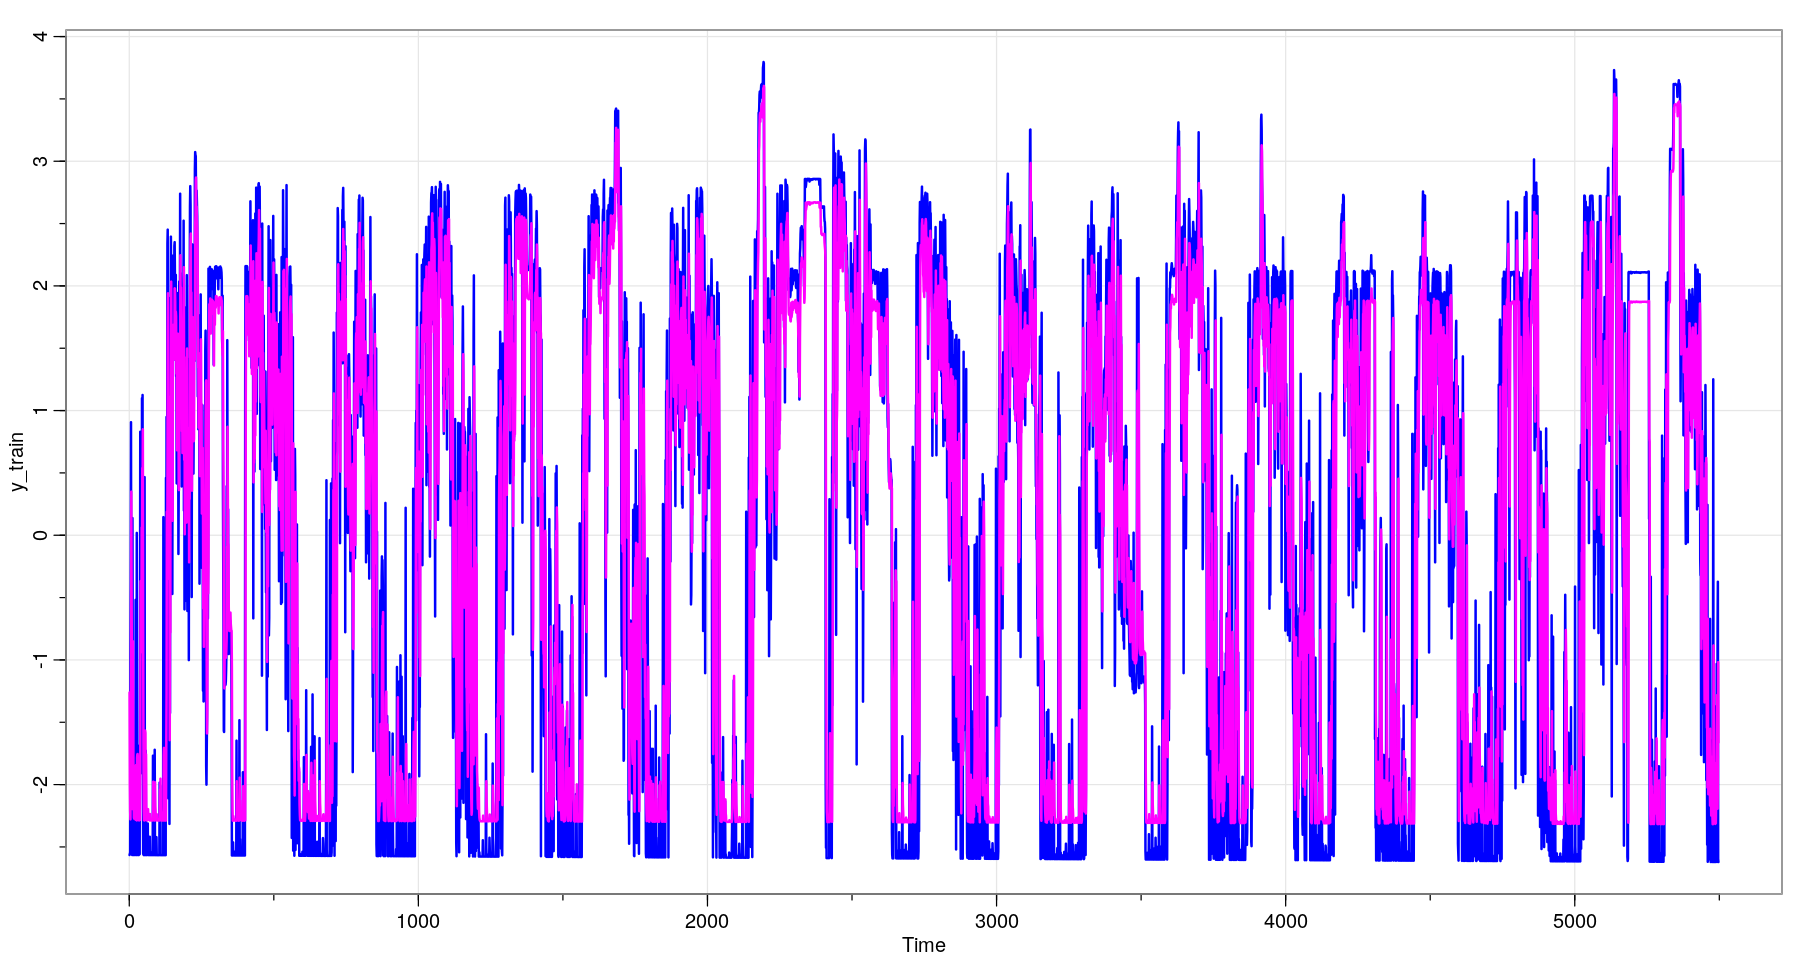

In [63]:
y7 = predict(model7,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y7, col=6, lwd=2)

## Modelo 8: LSTM +  capas

Agreguemos alguna capa densa más.

In [64]:
# initialize our model
model8 <- keras_model_sequential()

model8 %>%
    layer_dense(input_shape = dim(X_train)[2:3], units = 8, activation = "relu") %>%
    layer_lstm(units = 8, activation="relu") %>%
    layer_dense(units = 8, activation="relu") %>%
    layer_dense(units = 1)

In [65]:
summary(model8)

Model: "sequential_7"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_11 (Dense)                    (None, 3, 8)                    32          
________________________________________________________________________________
lstm_1 (LSTM)                       (None, 8)                       544         
________________________________________________________________________________
dense_12 (Dense)                    (None, 8)                       72          
________________________________________________________________________________
dense_13 (Dense)                    (None, 1)                       9           
Total params: 657
Trainable params: 657
Non-trainable params: 0
________________________________________________________________________________


In [66]:
model8 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [67]:
trained_model8 <- model8 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


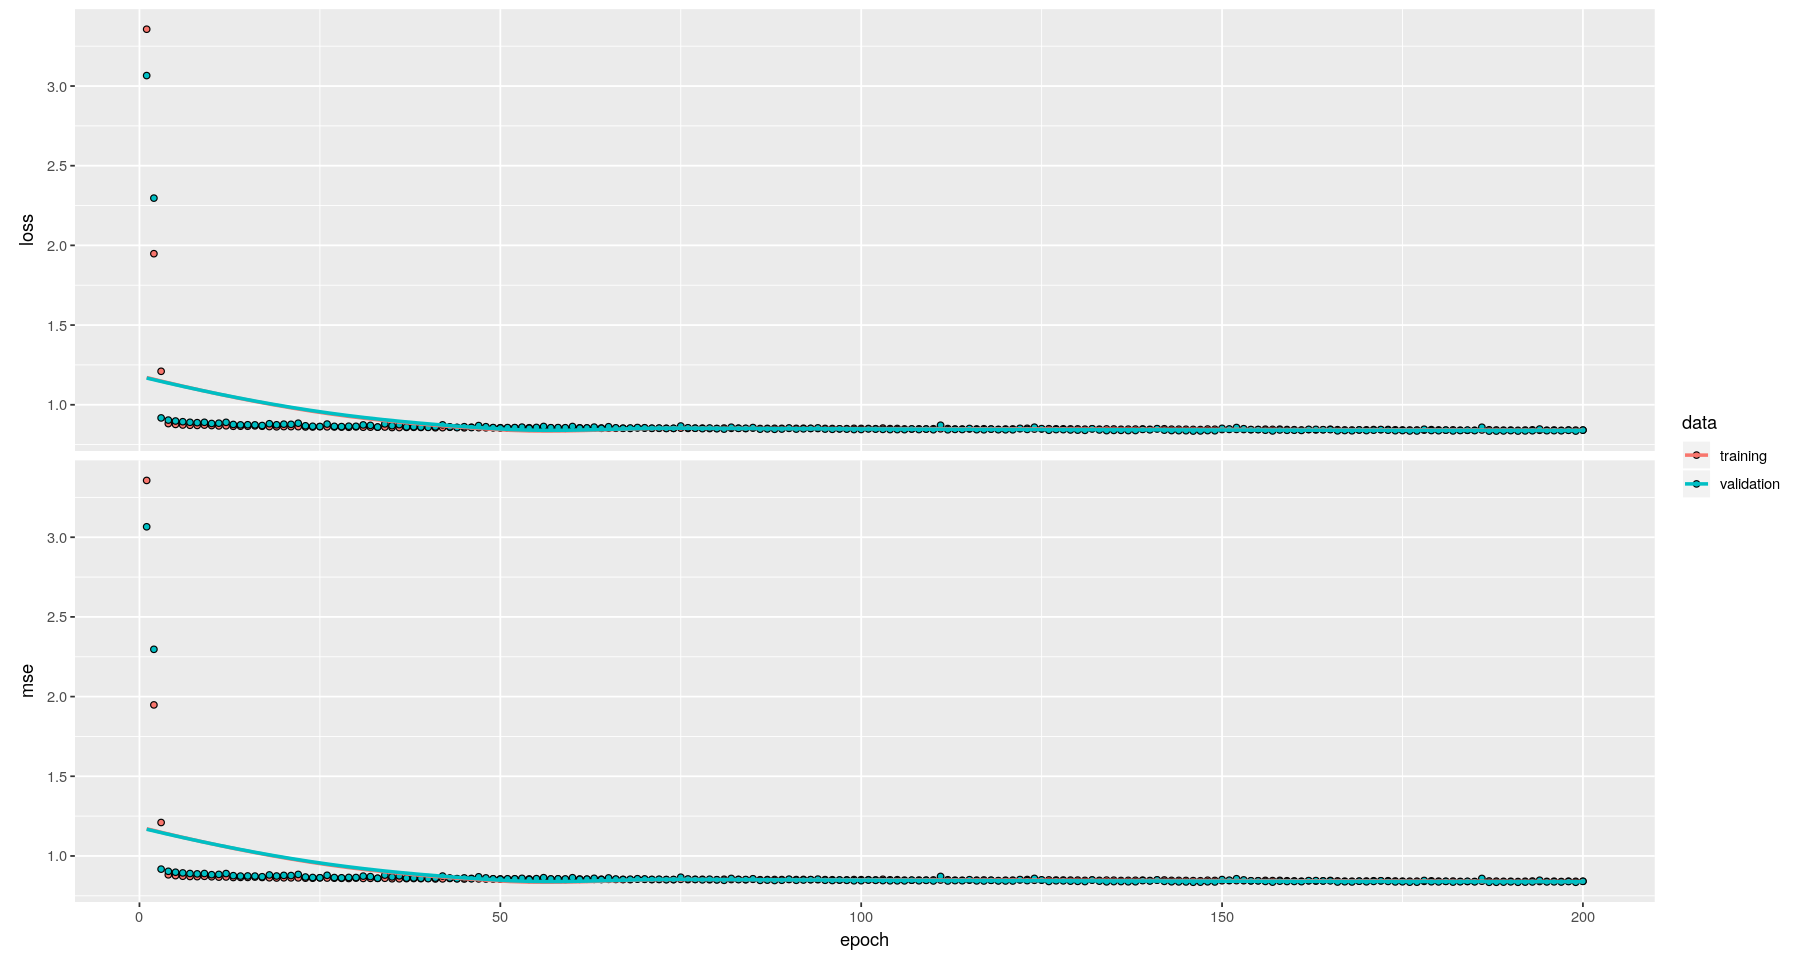

In [68]:
plot(trained_model8)

In [69]:
evaluate(model8, X_train, y_train)

loss       mse 
0.8386781 0.8386781

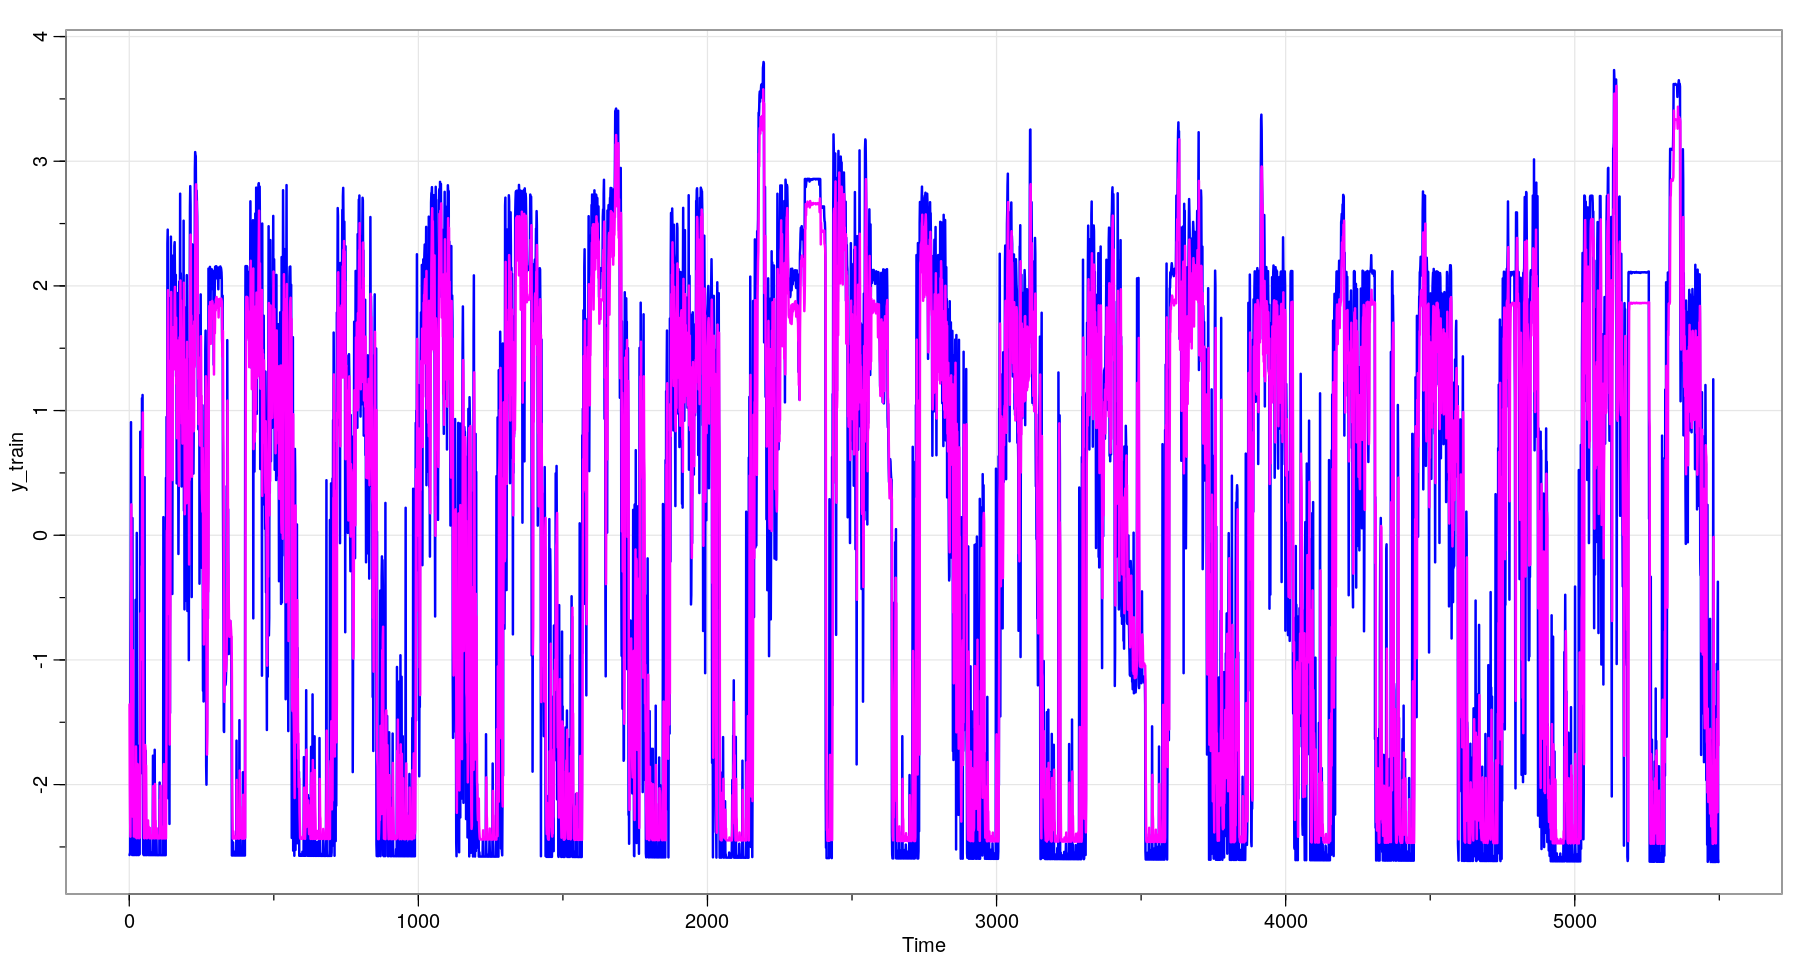

In [70]:
y8 = predict(model8,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y8, col=6, lwd=2)

## Evaluación.

Evaluemos algunos de estos modelos haciendo la predicción sobre los años que faltan.

In [71]:
x_test = x[time(x)>=5500]
x_test = ts(x_test, start=5500, freq=1)

sint = sin(2*pi*time(x_test))
cost = cos(2*pi*time(x_test))

In [72]:
n=length(x_test)

X_test = array(,dim=c(n-window-pred+1,window,3)) #el ultimo son los features
y_test = matrix(,n-window-pred+1,pred)

for (i in 1:(n-window-pred+1)) {
    X_test[i,,1] = x[i:(i+window-1)]
    X_test[i,,2] = sint[i:(i+window-1)]
    X_test[i,,3] = cost[i:(i+window-1)]
    y_test[i,] = x[(i+window):(i+window+pred-1)]
}
dim(X_test)
dim(y_test)

[1] 545   3   3

[1] 545   1

In [73]:
evaluate(model8,X_test,y_test)

loss       mse 
0.8059292 0.8059292

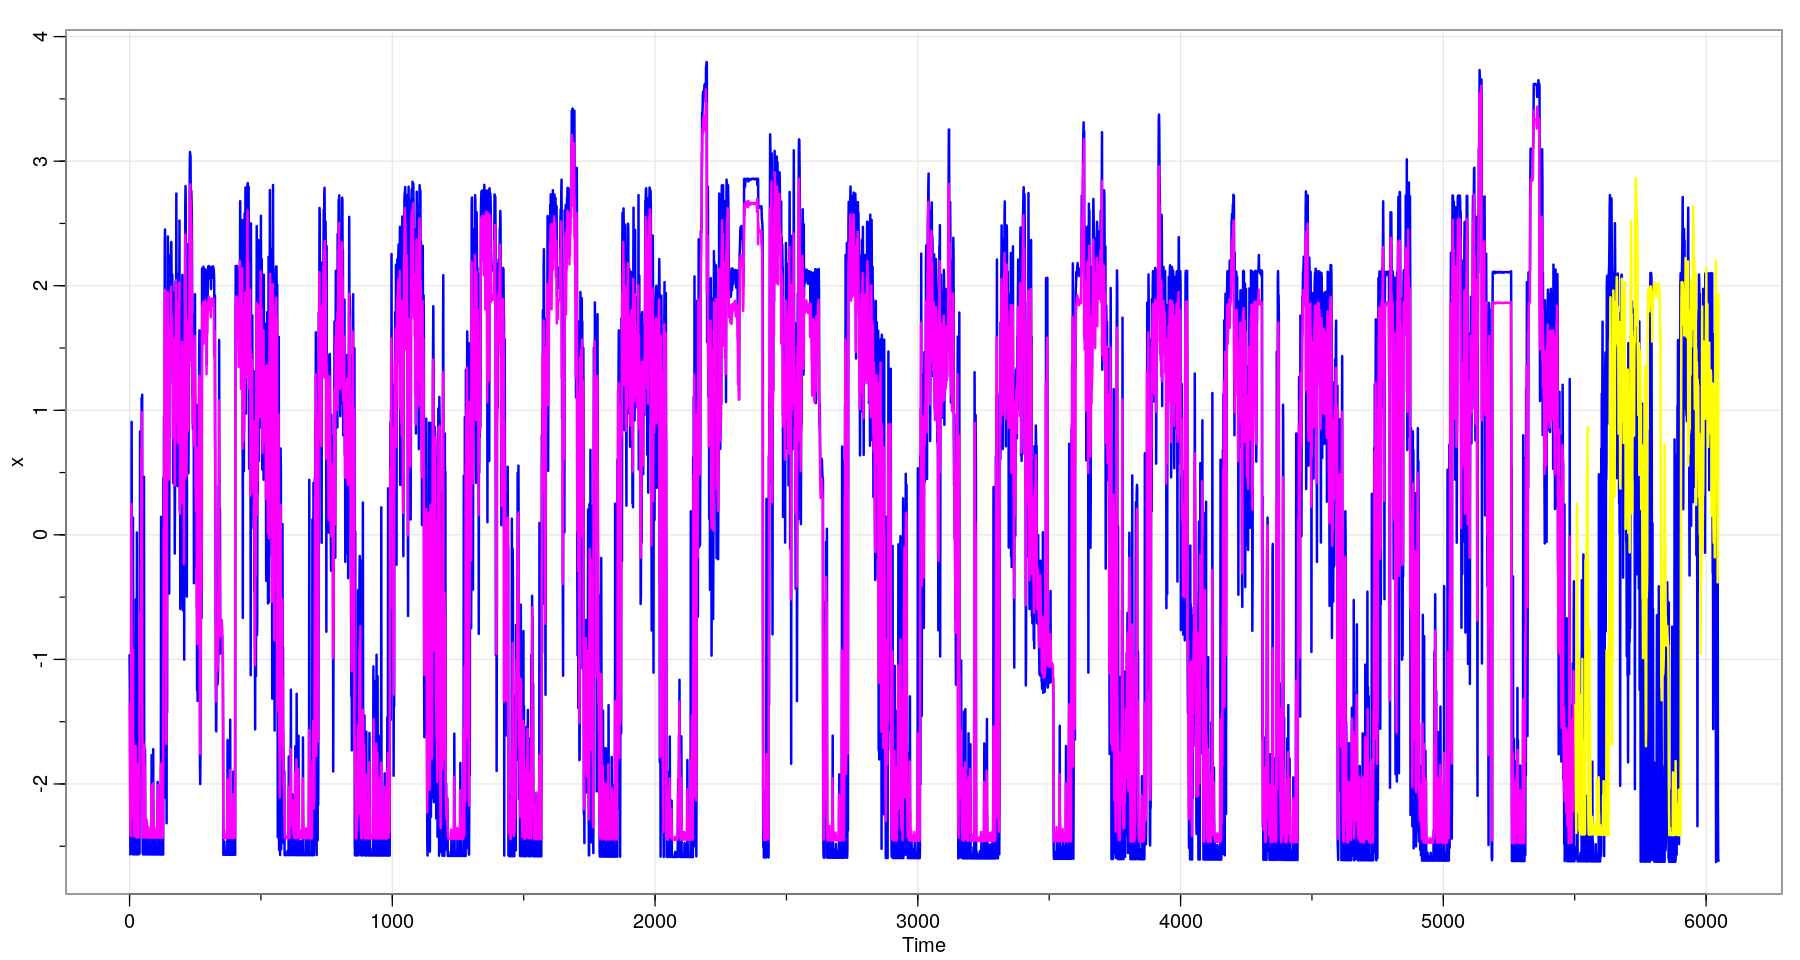

In [74]:
y8_test = predict(model3,X_test)
y8_test = ts(y8_test, start=5500+3, freq=1)
#y8 = ts(y8, start=1970, freq=52)

tsplot(x, col=4, lwd=2)
lines(y8, col=6, lwd=2)
lines(y8_test, col=7, lwd=2)

In [75]:
ts_test_trn = ts(fitted(fit), start=1, freq=1)
#tsplot(ts_test_trn, col=4, lwd=2)
length(ts_test_trn)

[1] 6048

In [76]:
length(y8)
length(y8_test)

[1] 5497

[1] 545

In [77]:
time(x)

A Time Series:
   [1]    0    1    2    3    4    5    6    7    8    9   10   11   12   13
  [15]   14   15   16   17   18   19   20   21   22   23   24   25   26   27
  [29]   28   29   30   31   32   33   34   35   36   37   38   39   40   41
  [43]   42   43   44   45   46   47   48   49   50   51   52   53   54   55
  [57]   56   57   58   59   60   61   62   63   64   65   66   67   68   69
  [71]   70   71   72   73   74   75   76   77   78   79   80   81   82   83
  [85]   84   85   86   87   88   89   90   91   92   93   94   95   96   97
  [99]   98   99  100  101  102  103  104  105  106  107  108  109  110  111
 [113]  112  113  114  115  116  117  118  119  120  121  122  123  124  125
 [127]  126  127  128  129  130  131  132  133  134  135  136  137  138  139
 [141]  140  141  142  143  144  145  146  147  148  149  150  151  152  153
 [155]  154  155  156  157  158  159  160  161  162  163  164  165  166  167
 [169]  168  169  170  171  172  173  174  175  176  177  178  179  180  181
 [183]  182  183  184  185  186  187  188  189  190  191  192  193  194  195
 [197]  196  197  198  199  200  201  202  203  204  205  206  207  208  209
 [211]  210  211  212  213  214  215  216  217  218  219  220  221  222  223
 [225]  224  225  226  227  228  229  230  231  232  233  234  235  236  237
 [239]  238  239  240  241  242  243  244  245  246  247  248  249  250  251
 [253]  252  253  254  255  256  257  258  259  260  261  262  263  264  265
 [267]  266  267  268  269  270  271  272  273  274  275  276  277  278  279
 [281]  280  281  282  283  284  285  286  287  288  289  290  291  292  293
 [295]  294  295  296  297  298  299  300  301  302  303  304  305  306  307
 [309]  308  309  310  311  312  313  314  315  316  317  318  319  320  321
 [323]  322  323  324  325  326  327  328  329  330  331  332  333  334  335
 [337]  336  337  338  339  340  341  342  343  344  345  346  347  348  349
 [351]  350  351  352  353  354  355  356  357  358  359  360  361  362  363
 [365]  364  365  366  367  368  369  370  371  372  373  374  375  376  377
 [379]  378  379  380  381  382  383  384  385  386  387  388  389  390  391
 [393]  392  393  394  395  396  397  398  399  400  401  402  403  404  405
 [407]  406  407  408  409  410  411  412  413  414  415  416  417  418  419
 [421]  420  421  422  423  424  425  426  427  428  429  430  431  432  433
 [435]  434  435  436  437  438  439  440  441  442  443  444  445  446  447
 [449]  448  449  450  451  452  453  454  455  456  457  458  459  460  461
 [463]  462  463  464  465  466  467  468  469  470  471  472  473  474  475
 [477]  476  477  478  479  480  481  482  483  484  485  486  487  488  489
 [491]  490  491  492  493  494  495  496  497  498  499  500  501  502  503
 [505]  504  505  506  507  508  509  510  511  512  513  514  515  516  517
 [519]  518  519  520  521  522  523  524  525  526  527  528  529  530  531
 [533]  532  533  534  535  536  537  538  539  540  541  542  543  544  545
 [547]  546  547  548  549  550  551  552  553  554  555  556  557  558  559
 [561]  560  561  562  563  564  565  566  567  568  569  570  571  572  573
 [575]  574  575  576  577  578  579  580  581  582  583  584  585  586  587
 [589]  588  589  590  591  592  593  594  595  596  597  598  599  600  601
 [603]  602  603  604  605  606  607  608  609  610  611  612  613  614  615
 [617]  616  617  618  619  620  621  622  623  624  625  626  627  628  629
 [631]  630  631  632  633  634  635  636  637  638  639  640  641  642  643
 [645]  644  645  646  647  648  649  650  651  652  653  654  655  656  657
 [659]  658  659  660  661  662  663  664  665  666  667  668  669  670  671
 [673]  672  673  674  675  676  677  678  679  680  681  682  683  684  685
 [687]  686  687  688  689  690  691  692  693  694  695  696  697  698  699
 [701]  700  701  702  703  704  705  706  707  708  709  710  711  712  713
 [715]  714  715  716  717  718  719  720  721  722  723  

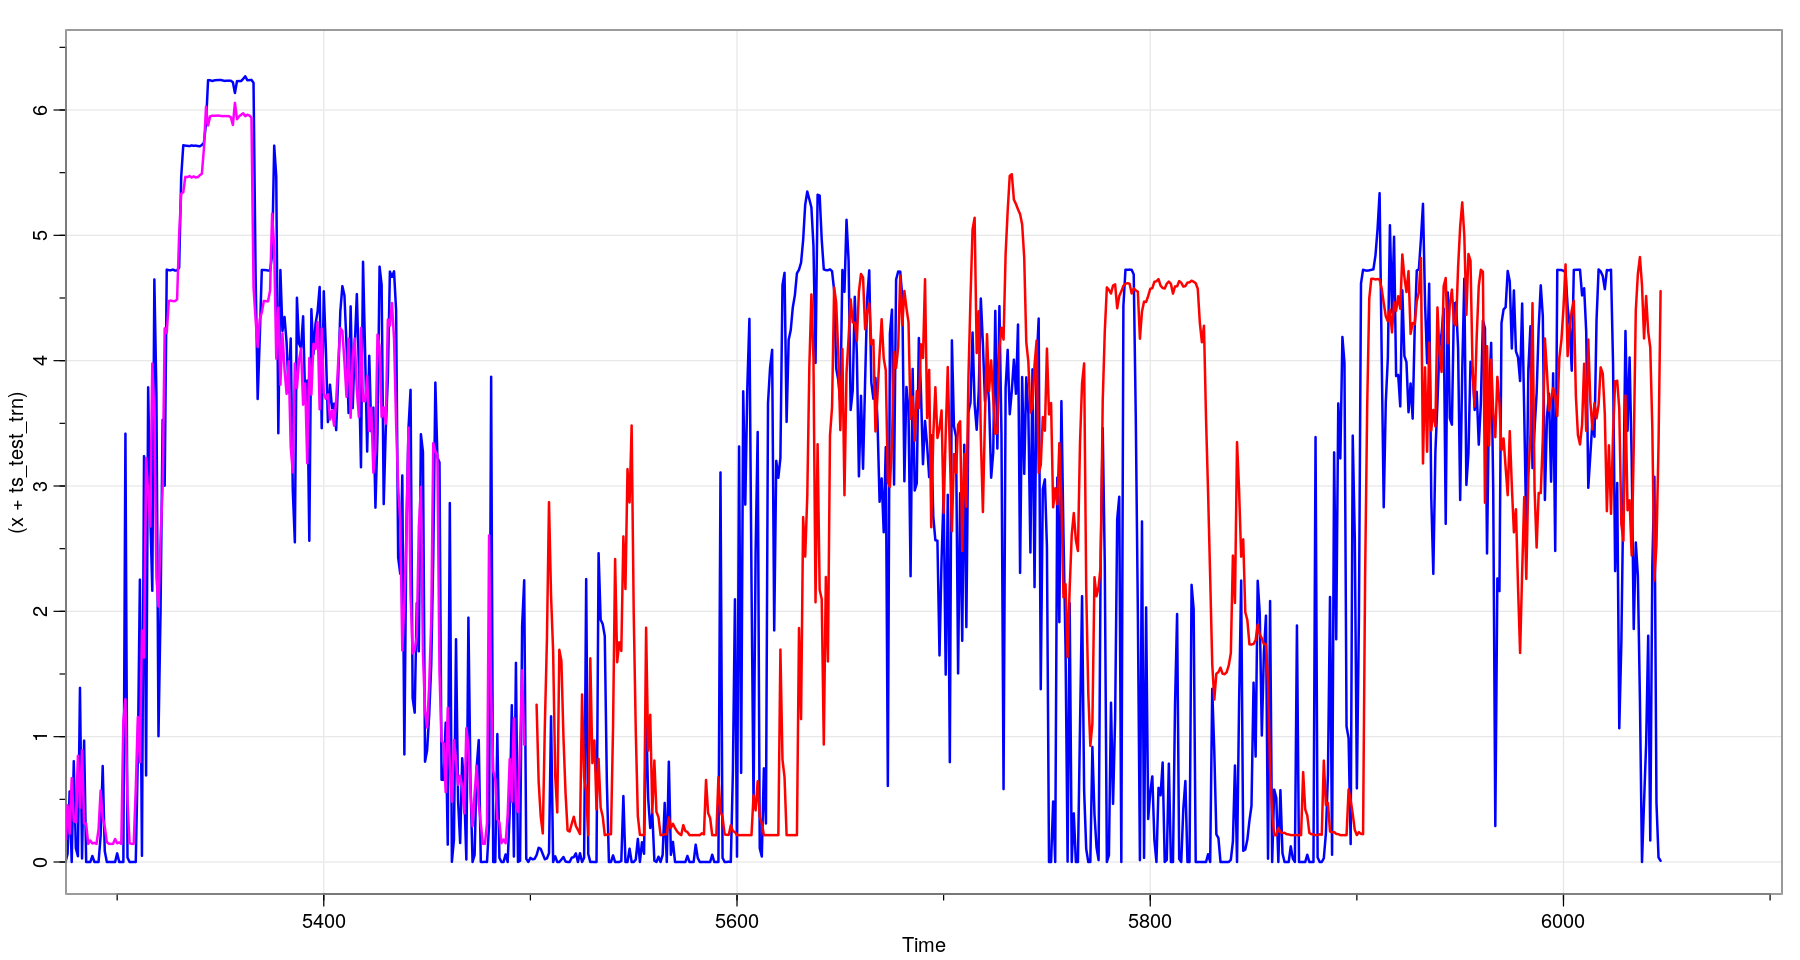

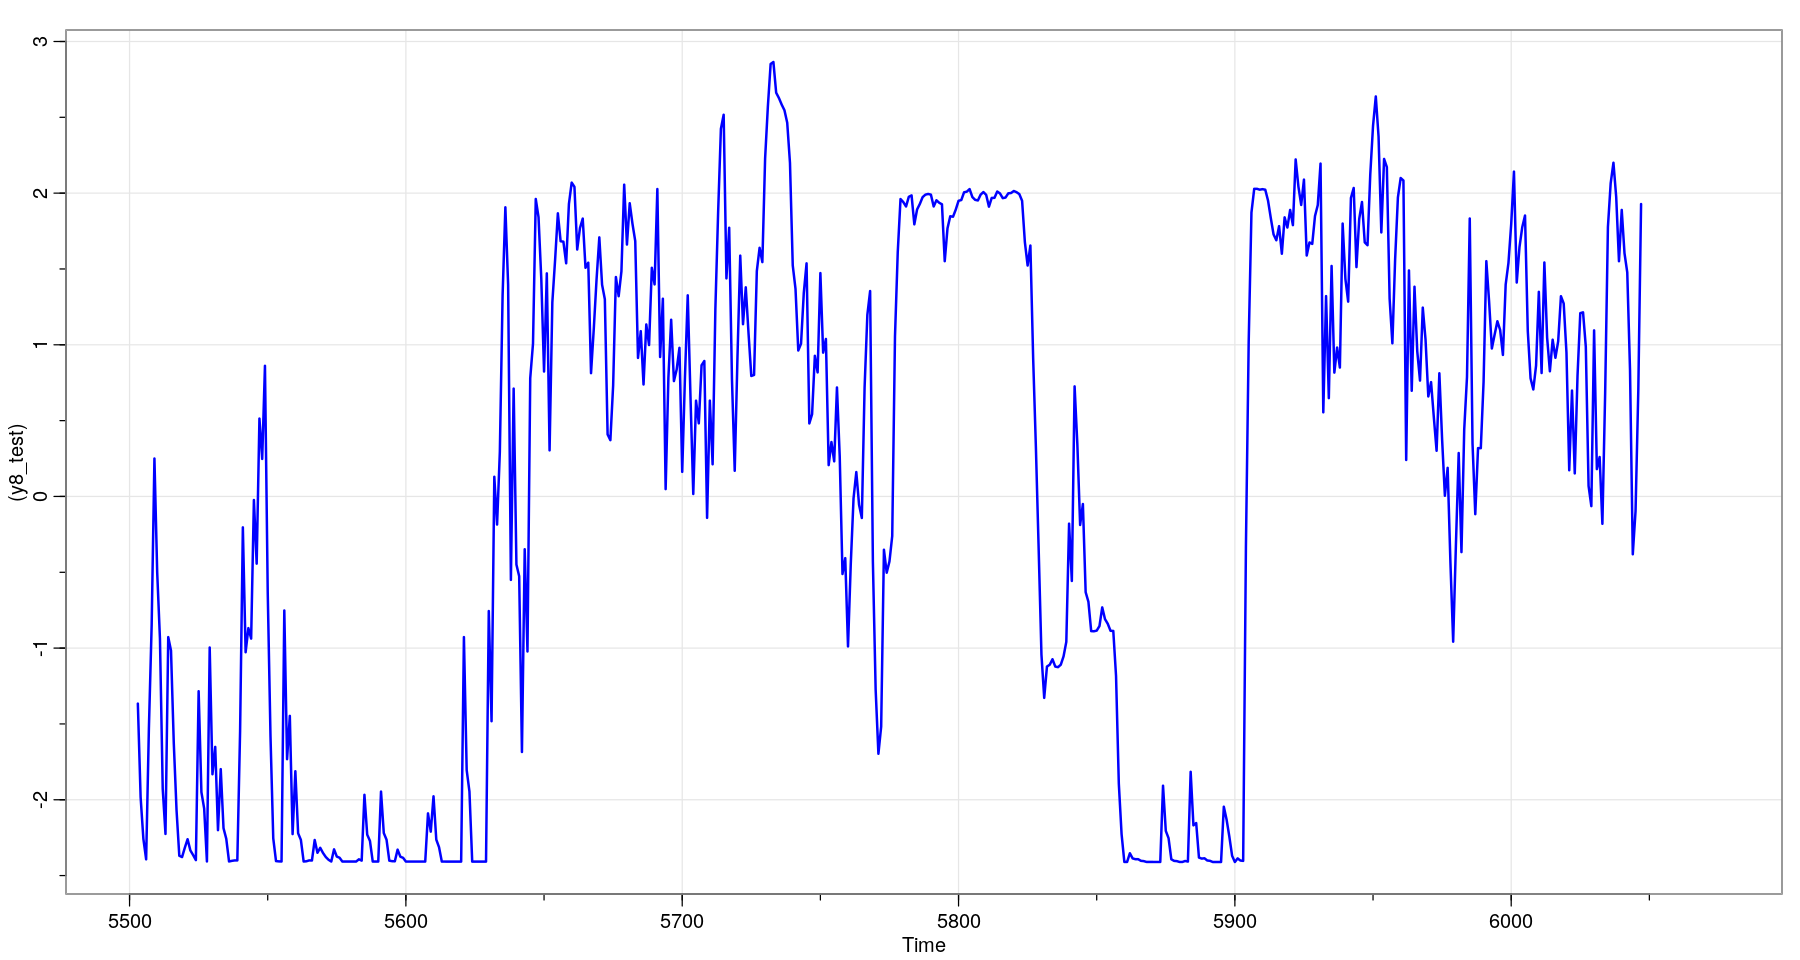

In [78]:

tsplot((x+ts_test_trn), col=4, lwd=2, xlim=c(5306,6075))
lines((y8+ts_test_trn[1:5497]), col=6, lwd=2)
lines((y8_test+ts_test_trn[5500:6044]), col=2, lwd=2)
tsplot((y8_test), col=4, lwd=2, xlim=c(5500,6075))

In [79]:
#y8_test+ts_test_trn[5500:6044]

In [80]:
#length(y8_test)

In [81]:
#length(ts_test_trn[5500:6044])

In [82]:
length(y8)

[1] 5497

In [83]:
length(ts_test_trn)

[1] 6048